# Consolidated Economic Analysis Notebook
**Deliverable:** Single notebook containing *all* project code, data exploration, cleaning, descriptive analytics, and econometric modelling.

**Generated:** 2025-05-09 15:54  

Run the notebook sequentially (**Kernel ▶ Run All**) to reproduce the full workflow without any external Python files.

## 0  Embedded source code

In [5]:
# ===== helpers.py =====
"""
Helper functions for data analysis and visualization.
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

def plot_missing(df, out_path):
    """
    Visualize missing data in the DataFrame with a heatmap showing data availability by country and year.
    
    If the DataFrame contains panel data with 'Country' and 'Year' columns, it will create a heatmap
    showing data availability for each country across years for the selected variables.
    
    Args:
        df (pd.DataFrame): DataFrame to visualize missing values, should contain 'Country' and 'Year' columns
        out_path (str): Path to save the figure
        
    Returns:
        None
    """
    # Check if the DataFrame has Country and Year columns for panel data
    if 'Country' in df.columns and 'Year' in df.columns:
        # Identify the variables to visualize (exclude Country and Year)
        data_vars = [col for col in df.columns if col not in ['Country', 'Year']]
        
        if len(data_vars) == 0:
            print("No data variables found besides Country and Year")
            return None
        
        # For each variable, create a heatmap showing data availability
        for var in data_vars:
            # Create a pivot table with countries as rows and years as columns
            pivot_df = df.pivot_table(
                index='Country', 
                columns='Year', 
                values=var,
                aggfunc=lambda x: 1.0 if pd.notnull(x).any() else 0.0
            )
            
            # Create the figure
            plt.figure(figsize=(15, 10))
            
            # Create the heatmap
            sns.heatmap(
                pivot_df, 
                cmap='Blues', 
                cbar_kws={'label': 'Data Available'},
                vmin=0, 
                vmax=1
            )
            
            # Set title and labels
            title = f"Data Availability for {var.replace('lnpovhead215', 'Poverty headcount ratio at $2.15 a day').replace('lnpovhead', 'Poverty headcount ratio at $3.65 a day')} ({df['Year'].min()}-{df['Year'].max()})"
            plt.title(title, fontsize=14)
            plt.xlabel('Year', fontsize=12)
            plt.ylabel('Country', fontsize=12)
            plt.tight_layout()
            
            # Ensure the directory exists
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            
            # Create a variable-specific output path
            base_path = os.path.splitext(out_path)[0]  # Get the path without extension
            # Remove any existing instances of the variable name in the base path
            if f"_{var}" in base_path:
                base_path = base_path.replace(f"_{var}", "")
            var_out_path = f"{base_path}_{var}.png"
            
            # Save the figure
            plt.savefig(var_out_path, bbox_inches='tight', dpi=300)
            plt.close()
        
        return None
    
    # If not a panel dataset, use the default missingno matrix
    plt.figure(figsize=(12, 8))
    msno.matrix(df, figsize=(12, 8))
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    
    # Save the figure
    plt.savefig(out_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    return None

def vif_table(df, cols, out_path="reports/tables/vif.xlsx"):
    """
    Calculate Variance Inflation Factors for specified columns and export to Excel.
    
    Args:
        df (pd.DataFrame): Input data
        cols (list): List of column names to calculate VIF for
        out_path (str, optional): Path to save the Excel file. Defaults to "reports/tables/vif.xlsx".
    
    Returns:
        pd.DataFrame: DataFrame containing VIF values
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    # Create a DataFrame with only the desired columns
    X = df[cols].dropna()
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Variable"] = cols
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Sort by VIF (highest first)
    vif_data = vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)
    
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    
    # Export to Excel
    vif_data.to_excel(out_path, index=False)
    
    return vif_data

def export_reg_table(res_dict, tag, folder="reports/tables"):
    """
    Export regression results to tables in Excel and LaTeX formats.
    
    Args:
        res_dict (dict): Dictionary of regression results
            Keys are model names, values are statsmodels results objects
        tag (str): Identifier for the output files
        folder (str, optional): Folder to save output files. Defaults to "reports/tables".
    
    Returns:
        None
    """
    import statsmodels.api as sm
    
    # Ensure the output directory exists
    os.makedirs(folder, exist_ok=True)
    
    # Combine results into a summary table
    results_table = sm.summary2.summary_col(
        results=list(res_dict.values()),
        float_format='%0.3f',
        stars=True,
        model_names=list(res_dict.keys()),
        regressor_order=[v.model.exog_names for v in res_dict.values()][0]
    )
    
    # Get the summary as a DataFrame
    results_df = results_table.tables[0]
    
    # Export to Excel
    excel_path = os.path.join(folder, f"regression_{tag}.xlsx")
    results_df.to_excel(excel_path)
    
    # Export to LaTeX
    latex_path = os.path.join(folder, f"regression_{tag}.tex")
    
    # Create a more publication-ready LaTeX table
    latex_table = results_table.as_latex()
    
    # Replace some LaTeX formatting for better output
    latex_table = latex_table.replace('\\begin{center}', '\\begin{table}[htbp]\n\\centering')
    latex_table = latex_table.replace('\\end{center}', '\\caption{Regression Results}\n\\label{tab:reg_' + tag + '}\n\\end{table}')
    
    # Write the LaTeX table to a file
    with open(latex_path, 'w') as f:
        f.write(latex_table)
    
    return None 

In [6]:
# ===== data_cleaning.py =====
"""
Data cleaning script that combines functionality from:
- data_cleaning.py
- GII_Processing.ipynb
- FI Index.ipynb
- FI Index copy.ipynb
- Instruments.py

Changes:
- Modified input paths from raw_data/ to data/raw/
- Modified output paths to data/interim/ and data/processed/
"""
import pandas as pd
import re
import os
import sys
import numpy as np
from pathlib import Path
import warnings
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Suppress pandas warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Create directories if they don't exist
try:
    os.makedirs('data/raw', exist_ok=True)
    os.makedirs('data/interim', exist_ok=True)
    os.makedirs('data/processed', exist_ok=True)
    print("Directory structure validated.")
except Exception as e:
    print(f"Error creating directories: {e}")
    sys.exit(1)

def clean_fas_data():
    """
    Clean the Financial Access Survey (FAS) data.
    Read from data/raw/FAS.csv
    Save to data/interim/FAS_cleaned.csv
    """
    # Read the FAS.csv file
    file_path = 'data/raw/FAS.csv'
    data = pd.read_csv(file_path)
    print("FAS.csv - Initial Data:")
    print(data.head())

    # Define the list of countries to keep
    countries_to_keep = [
        'Mexico', 'Peru', 'Belize', 'Costa Rica', 'El Salvador', 'Guatemala',
        'Honduras', 'Nicaragua', 'Panama', 'Cuba', 'Dominican Republic', 'Haiti',
        'Puerto Rico', 'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia',
        'Ecuador', 'Guyana', 'Paraguay', 'Suriname', 'Uruguay', 'Venezuela, República Bolivariana de'
    ]

    # Filter the data to keep only the specified countries
    data_filtered = data[data['COUNTRY'].isin(countries_to_keep)]

    # Exceptional name standardization for 'Venezuela, República Bolivariana de'
    # the ' sign leading to missing values in the COUNTRY column after exporting to csv
    # Replacing Venezuel, República Bolivariana de with Venezuela
    data_filtered['COUNTRY'] = data_filtered['COUNTRY'].replace('Venezuela, República Bolivariana de', 'Venezuela')

    # Columns to delete
    delete_columns = [
        'DATASET', 'SERIES_CODE', 'OBS_MEASURE', 'FREQUENCY',
        'SCALE', 'PRECISION', 'DECIMALS_DISPLAYED', 'INSTR_ASSET', 'FA_INDICATORS',
        'SECTOR', 'COUNTERPART_SECTOR', 'ACCOUNTING_ENTRY', 'SEX', 'TRANSFORMATION',
        'UNIT', 'DERIVATION_TYPE', 'OVERLAP', 'STATUS', 'DOI', 'FULL_DESCRIPTION',
        'AUTHOR', 'PUBLISHER', 'DEPARTMENT', 'CONTACT_POINT', 'TOPIC', 'TOPIC_DATASET',
        'KEYWORDS', 'KEYWORDS_DATASET', 'LANGUAGE', 'PUBLICATION_DATE', 'UPDATE_DATE',
        'METHODOLOGY', 'METHODOLOGY_NOTES', 'ACCESS_SHARING_LEVEL', 'ACCESS_SHARING_NOTES',
        'SECURITY_CLASSIFICATION', 'SOURCE', 'SHORT_SOURCE_CITATION', 'FULL_SOURCE_CITATION',
        'LICENSE', 'SUGGESTED_CITATION', 'KEY_INDICATOR', 'SERIES_NAME'
    ]

    # Drop the specified columns
    data_cleaned = data_filtered.drop(columns=delete_columns)

    selected_indicators = [
    # Branches
    'Branches excluding headquarters, Other deposit takers',
    'Branches excluding headquarters, Commercial banks',
    'Branches excluding headquarters, Credit unions and credit cooperatives',
    'Branches excluding headquarters, Deposit taking microfinance institutions',
    'Branches excluding headquarters, Non-deposit taking microfinance institutions',
    'Number of commercial bank branches',
    'Number of credit union and credit cooperative branches',
    'Number of other deposit taker branches',
    'Number of all microfinance institution branches',

    # ATMs
    'Number of automated teller machines (ATMs)',

    # Depositors 
    'Number of depositors, Commercial banks',
    'Depositors, Deposit taking microfinance institutions',
    'Depositors, Commercial banks',
    'Number of depositors, Commercial banks',
    'Number of depositors, Credit unions and credit cooperatives',

    # Deposit accounts 
    'Number of deposit accounts, Commercial banks',
    'Deposit accounts, Commercial banks',
    'Deposit accounts, Deposit taking microfinance institutions',
    'Deposit accounts, Credit unions and credit cooperatives',
    'Number of deposit accounts, Commercial banks',
    'Number of deposit accounts, Credit unions and credit cooperatives',

    # Borrowers
    'Number of borrowers, Commercial banks',
    'Borrowers, Commercial banks',
    'Borrowers, Deposit taking microfinance institutions',
    'Borrowers, Credit unions and credit cooperatives',
    'Borrowers, Non-deposit taking microfinance institutions',

    # Loan accounts
    'Number of loan accounts, Commercial banks',
    'Loan accounts, Commercial banks',
    'Loan accounts, Deposit taking microfinance institutions',
    'Loan accounts, Credit unions and credit cooperatives',
    'Loan accounts, Non-deposit taking microfinance institutions',
    ]

    data_cleaned_filtered_indicators = data_cleaned[data_cleaned['INDICATOR'].isin(selected_indicators)]

    # Steps to convert the data to long format
    # 1) Identify the year-columns via regex (exactly four digits)
    year_cols = [col for col in data_cleaned_filtered_indicators.columns if re.fullmatch(r"\d{4}", col)]

    # 2) Melt into long format
    df_long = data_cleaned_filtered_indicators.melt(
        id_vars=["COUNTRY", "INDICATOR", 'TYPE_OF_TRANSFORMATION'],
        value_vars=year_cols,
        var_name="year",
        value_name="value"
    )

    # 3) Convert types
    df_long["year"] = df_long["year"].astype(int)
    df_long["value"] = pd.to_numeric(df_long["value"], errors="coerce")

    # Filter for the years 2004 to 2023
    df_long = df_long[(df_long['year'] >= 2004) & (df_long['year'] <= 2023)]
   
    # Sort the DataFrame by country, Indicator and year
    df_long = df_long.sort_values(by=["COUNTRY", "INDICATOR", "year"])

    # Save the cleaned data to a new CSV file
    df_long.to_csv('data/interim/FAS_cleaned.csv', index=False)
    print("FAS.csv cleaning complete. 'data/interim/FAS_cleaned.csv' has been created.")


def clean_wgi_data():
    """
    Clean the World Governance Indicators (WGI) data.
    Read from data/raw/WGI.csv
    Save to data/interim/WGI_cleaned.csv
    """
    # Read the WGI.csv file
    file_path = 'data/raw/WGI.csv'
    data = pd.read_csv(file_path, delimiter=';')
    print("WGI.csv - Initial Data:")
    print(data.head())

    # Define the list of countries to keep
    countries_to_keep = [
        'Mexico', 'Peru', 'Belize', 'Costa Rica', 'El Salvador', 'Guatemala',
        'Honduras', 'Nicaragua', 'Panama', 'Cuba', 'Dominican Republic', 'Haiti',
        'Puerto Rico', 'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia',
        'Ecuador', 'Guyana', 'Paraguay', 'Suriname', 'Uruguay', 'Venezuela, RB'
    ]

    # Delete the 'codeindyr' and 'code' columns
    data = data.drop(columns=['codeindyr', 'code'])

    # Filter rows where 'indicator' is 'rl'
    data_filtered = data[data['indicator'] == 'rl']

    # Delete the 'indicator' column
    data_cleaned = data_filtered.drop(columns=['indicator'])
    
    # Filter to keep only rows for the specified countries
    data_cleaned = data_cleaned[data_cleaned['countryname'].isin(countries_to_keep)]

    print("WGI.csv - Cleaned Data:")
    print(data_cleaned.head())

    # Save the cleaned data to a new CSV file
    data_cleaned.to_csv('data/interim/WGI_cleaned.csv', index=False)

    print("WGI.csv cleaning complete. 'data/interim/WGI_cleaned.csv' has been created.")


def clean_wdi_data():
    """
    Clean the World Development Indicators (WDI) data.
    Read from data/raw/WDI.csv
    Save to data/interim/WDI_cleaned.csv
    """
    # Read the WDI.csv file
    file_path = 'data/raw/WDI.csv'
    data = pd.read_csv(file_path)
    print("WDI.csv - Initial Data:")
    print(data.head())

    # Delete the 'Country Code' and 'Series Code' columns
    data = data.drop(columns=['Country Code', 'Series Code'])

    # Remove ' [YRxxxx]' from year columns
    data.columns = data.columns.str.replace(r' \[YR\d{4}\]', '', regex=True)

    print("WDI.csv - Cleaned Data:")
    print(data.head())

    # Save the cleaned data to a new CSV file
    data.to_csv('data/interim/WDI_cleaned.csv', index=False)

    print("WDI.csv cleaning complete. 'data/interim/WDI_cleaned.csv' has been created.")


def clean_wid_data():
    """
    Clean the World Inequality Database (WID) data.
    Read from data/raw/WID.csv
    Save to data/interim/WID_cleaned.csv
    """
    # Read the WID.csv file
    file_path = 'data/raw/WID.csv'
    data = pd.read_csv(file_path, delimiter=';')
    print("WID.csv - Initial Data:")
    print(data.head())

    # Delete the 'Percentile' column
    data = data.drop(columns=['Percentile'])

    # Pivot the data so that years are columns and countries are rows
    data_pivoted = data.set_index('Year').T

    # Rename the first column to 'Country'
    data_pivoted.index.name = 'Country'

    print("WID.csv - Cleaned Data:")
    print(data_pivoted.head())

    # Save the cleaned data to a new CSV file
    data_pivoted.to_csv('data/interim/WID_cleaned.csv')

    print("WID.csv cleaning complete. 'data/interim/WID_cleaned.csv' has been created.")


def clean_gii_data():
    """
    Clean the Gender Inequality Index (GII) data.
    Read from data/raw/GII.csv
    Save to data/interim/GII_cleaned.csv
    
    Adapted from GII_Processing.ipynb
    """
    # Read the GII.csv file (attempting with different encodings)
    file_path = 'data/raw/GII.csv'
    
    try:
        # First try with UTF-8 encoding
        print(f"Attempting to read {file_path} with UTF-8 encoding...")
        data = pd.read_csv(file_path)
    except UnicodeDecodeError:
        try:
            # If that fails, try with Latin-1 encoding
            print(f"UTF-8 encoding failed. Attempting with Latin-1 encoding...")
            data = pd.read_csv(file_path, encoding='latin1')
        except Exception as e:
            # If that also fails, try with Windows-1252 encoding (common for Windows files)
            print(f"Latin-1 encoding failed. Attempting with Windows-1252 encoding...")
            try:
                data = pd.read_csv(file_path, encoding='cp1252')
            except Exception as e2:
                print(f"All encoding attempts failed. Error: {e2}")
                print("Skipping GII processing due to encoding issues.")
                return
    
    print("GII.csv - Initial Data:")
    print(data.head())
    
    # Define the list of countries to keep
    countries_to_keep = [
        'Mexico', 'Peru', 'Belize', 'Costa Rica', 'El Salvador', 'Guatemala',
        'Honduras', 'Nicaragua', 'Panama', 'Cuba', 'Dominican Republic', 'Haiti',
        'Puerto Rico', 'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia',
        'Ecuador', 'Guyana', 'Paraguay', 'Suriname', 'Uruguay', 'Venezuela'
    ]
    
    # Check if 'country' column exists
    if 'country' not in data.columns:
        print("Warning: 'country' column not found in GII.csv")
        # Look for alternative column names
        possible_country_cols = [col for col in data.columns if 'country' in col.lower()]
        if possible_country_cols:
            print(f"Using '{possible_country_cols[0]}' as country column")
            data = data.rename(columns={possible_country_cols[0]: 'country'})
        else:
            print("Could not find a country column. Skipping GII processing.")
            return
    
    # Filter data to keep only rows for the specified countries
    data_filtered = data[data['country'].isin(countries_to_keep)]
    
    # Check if we have any GII-related columns
    gii_columns = [col for col in data.columns if 'gii' in col.lower()]
    
    if not gii_columns:
        print("Warning: No GII-related columns found in the data")
        print("Available columns:", data.columns.tolist())
        print("Skipping GII processing.")
        return
    
    print(f"Found {len(gii_columns)} GII-related columns: {gii_columns[:5]}...")
    
    # Extract GII-related columns
    country_column = ['country']
    selected_columns = country_column + gii_columns
    
    # Select only the needed columns
    data_cleaned = data_filtered[selected_columns]
    
    # Reshape data from wide to long format
    years = [col.split('_')[1] if '_' in col else col for col in gii_columns]
    id_vars = ['country']
    
    try:
        # Melt the data
        data_long = data_cleaned.melt(
            id_vars=id_vars,
            value_vars=gii_columns,
            var_name='year',
            value_name='gii_value'
        )
        
        # Extract year from the 'year' column
        if '_' in data_long['year'].iloc[0]:
            data_long['year'] = data_long['year'].str.replace(r'.*_', '', regex=True)
    except Exception as e:
        print(f"Error in melting GII data: {e}")
        print("Saving partially cleaned data instead.")
        data_cleaned.to_csv('data/interim/GII_cleaned.csv', index=False)
        return
    
    # Save the cleaned data
    data_long.to_csv('data/interim/GII_cleaned.csv', index=False)
    print("GII.csv cleaning complete. 'data/interim/GII_cleaned.csv' has been created.")


def standardize_country_names(file_path):
    """
    Standardize country names in a dataset.
    """
    # Read the cleaned CSV file
    data = pd.read_csv(file_path)
    
    # Define a mapping of country names to their standardized format
    country_name_mapping = {
        'Mexico': 'Mexico',
        'Peru': 'Peru',
        'Belize': 'Belize',
        'Costa Rica': 'Costa Rica',
        'El Salvador': 'El Salvador',
        'Guatemala': 'Guatemala',
        'Honduras': 'Honduras',
        'Nicaragua': 'Nicaragua',
        'Panama': 'Panama',
        'Cuba': 'Cuba',
        'Dominican Republic': 'Dominican Republic',
        'Haiti': 'Haiti',
        'Puerto Rico': 'Puerto Rico',
        'Argentina': 'Argentina',
        'Bolivia': 'Bolivia',
        'Brazil': 'Brazil',
        'Chile': 'Chile',
        'Colombia': 'Colombia',
        'Ecuador': 'Ecuador',
        'Guyana': 'Guyana',
        'Paraguay': 'Paraguay',
        'Suriname': 'Suriname',
        'Uruguay': 'Uruguay',
        'Venezuela': 'Venezuela',
        'Venezuela, RB': 'Venezuela',
    }
    
    # Check for possible column names for countries
    country_column = None
    if 'Country' in data.columns:
        country_column = 'Country'
    elif 'COUNTRY' in data.columns:
        country_column = 'COUNTRY'
    elif 'countryname' in data.columns:
        country_column = 'countryname'
    elif 'Country Name' in data.columns:
        country_column = 'Country Name'
    elif 'country' in data.columns:
        country_column = 'country'
    else:
        raise KeyError("No country column found in the dataset.")

    # Print the column names for debugging
    print(f"Columns in {file_path}: {data.columns.tolist()}")
    
    # Print the first few rows before standardization for debugging
    print(f"Data before standardization in {file_path}:")
    print(data.head())

    # Filter countries based on our list
    filtered_countries = ['Mexico', 'Peru', 'Belize', 'Costa Rica', 'El Salvador', 
                       'Guatemala', 'Honduras', 'Nicaragua', 'Panama', 'Cuba', 
                       'Dominican Republic', 'Haiti', 'Puerto Rico', 'Argentina', 
                       'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 
                       'Guyana', 'Paraguay', 'Suriname', 'Uruguay', 'Venezuela', 'Venezuela, RB']
    
    # Create a mask for rows that have countries in our list
    mask = data[country_column].isin(filtered_countries)
    
    # Apply mapping only to those rows
    data.loc[mask, country_column] = data.loc[mask, country_column].map(country_name_mapping)

    # Print the first few rows after standardization for debugging
    print(f"Data after standardization in {file_path}:")
    print(data.head())

    # Save the updated data back to the CSV file
    data.to_csv(file_path, index=False)

    print(f"Country names standardized in {file_path}.")


def merge_datasets():
    """
    Merge all cleaned datasets into a single comprehensive dataset.
    Read from data/interim/
    Save to data/processed/merged_dataset_1975_2024.csv
    """
    # Check which datasets are available
    interim_files = os.listdir('data/interim')
    print("Merging the following datasets:")
    for f in interim_files:
        # if f.endswith('_cleaned.csv'):
            print(f"  - {f}")
    
    # Initialize empty DataFrames
    fas = pd.DataFrame()
    wgi = pd.DataFrame()
    wdi = pd.DataFrame()
    wid = pd.DataFrame()
    gii = pd.DataFrame()
    instruments = pd.DataFrame()
    fi_index = pd.DataFrame()
    instruments_fii = pd.DataFrame()
    
    # Read all cleaned datasets if they exist
    if 'FAS_cleaned.csv' in interim_files:
        try:
            fas = pd.read_csv('data/interim/FAS_cleaned.csv')
            print(f"Loaded FAS data: {fas.shape[0]} rows, {fas.shape[1]} columns")
        except Exception as e:
            print(f"Error loading FAS data: {e}")
    
    if 'WGI_cleaned.csv' in interim_files:
        try:
            wgi = pd.read_csv('data/interim/WGI_cleaned.csv')
            print(f"Loaded WGI data: {wgi.shape[0]} rows, {wgi.shape[1]} columns")
        except Exception as e:
            print(f"Error loading WGI data: {e}")
    
    if 'WDI_cleaned.csv' in interim_files:
        try:
            wdi = pd.read_csv('data/interim/WDI_cleaned.csv')
            print(f"Loaded WDI data: {wdi.shape[0]} rows, {wdi.shape[1]} columns")
        except Exception as e:
            print(f"Error loading WDI data: {e}")
    
    if 'WID_cleaned.csv' in interim_files:
        try:
            wid = pd.read_csv('data/interim/WID_cleaned.csv')
            print(f"Loaded WID data: {wid.shape[0]} rows, {wid.shape[1]} columns")
        except Exception as e:
            print(f"Error loading WID data: {e}")
    
    if 'GII_cleaned.csv' in interim_files:
        try:
            gii = pd.read_csv('data/interim/GII_cleaned.csv')
            print(f"Loaded GII data: {gii.shape[0]} rows, {gii.shape[1]} columns")
        except Exception as e:
            print(f"Error loading GII data: {e}")
    
    if 'Instruments_Poverty_cleaned.csv' in interim_files:
        try:
            instruments = pd.read_csv('data/interim/Instruments_Poverty_cleaned.csv')
            print(f"Loaded Instruments data: {instruments.shape[0]} rows, {instruments.shape[1]} columns")
        except Exception as e:
            print(f"Error loading Instruments data: {e}")
    
    if 'FI_index.csv' in interim_files:
        try:
            fi_index = pd.read_csv('data/interim/FI_index.csv')
            print(f"Loaded FI_index data: {fi_index.shape}")
        except Exception as e:
            print(f"Error loading FI_index data: {e}")
    
    if 'Instruments_FII_lagged.csv' in interim_files:
        try:
            instruments_fii = pd.read_csv('data/interim/Instruments_FII_lagged.csv')
            print(f"Loaded Instruments_FII data: {instruments_fii.shape}")
        except Exception as e:
            print(f"Error loading Instruments_FII_lagged data: {e}")

    # Check if any datasets were loaded
    if all(df.empty for df in [fas, wgi, wdi, wid, gii, instruments, fi_index, instruments_fii]):
        print("No datasets available for merging. Exiting.")
        return
    
    print("Reading all cleaned datasets...")
    
    # Define the years range from 1975 to 2024
    years = list(range(1975, 2025))
    
    # Get the list of target countries - excluding the countries with worst data
    target_countries = [
        'Mexico', 'Peru', 'Costa Rica', 'El Salvador', 'Honduras', 
        'Nicaragua', 'Panama', 'Dominican Republic', 'Argentina', 
        'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 
        'Paraguay', 'Uruguay', 'Venezuela'
    ]
    
    # Create a multi-index DataFrame with countries and years
    index = pd.MultiIndex.from_product([target_countries, years], names=['Country', 'Year'])
    merged_data = pd.DataFrame(index=index).reset_index()
    
    # Initialize all data columns with NaN values
    # Variables as shown in the screenshot
    merged_data['GDP growth (annual %)'] = float('nan')
    merged_data['Population, total'] = float('nan')
    merged_data['Gini index'] = float('nan')
    merged_data['School enrollment, secondary (% gross)'] = float('nan')
    merged_data['Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)'] = float('nan')
    merged_data['Poverty headcount ratio at $3.65 a day (2017 PPP) (% of population)'] = float('nan')
    merged_data['General government final consumption expenditure (% of GDP)'] = float('nan')
    merged_data['Exports of goods and services (% of GDP)'] = float('nan')
    merged_data['Imports of goods and services (% of GDP)'] = float('nan')
    merged_data['Trade Openness (% of GDP)'] = float('nan')
    merged_data['Inflation, consumer prices (annual %)'] = float('nan')
    merged_data['Rule of Law - estimate'] = float('nan')
    merged_data['Rule of Law - pctrank'] = float('nan')
    merged_data['Wealth'] = float('nan')
    # merged_data['fi_index'] = float('nan')
    # merged_data['Access to electricity (% of population)'] = float('nan')
    # merged_data['Domestic credit to private sector (% of GDP)'] = float('nan')
    # merged_data['Commercial bank branches (per 100,000 adults)'] = float('nan')
    # merged_data['Urban population (% of total population)'] = float('nan')
    # merged_data['Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)']  = float('nan')
    # merged_data['Mobile cellular subscriptions (per 100 people)'] = float('nan')
    # merged_data['Individuals using the Internet (% of population)'] = float('nan')
    
    # Add Gender Inequality Index if available
    if not gii.empty:
        merged_data['Gender Inequality Index'] = float('nan')
    
    # Add additional indicator columns from instruments if available
    if not instruments.empty:
        merged_data['Poverty Rate $3.65'] = float('nan')
    
    # Add FI index columns
    if not fi_index.empty:
        for col in fi_index.columns:
            if col not in ('COUNTRY', 'year'):
                merged_data[col] = float('nan')

    # Add FII_instrument columns
    if not instruments_fii.empty:
        for col in instruments_fii.columns:
            if col not in ('Unnamed: 0', 'Country Name', 'year'):
                merged_data[col] = float('nan')

    print("Created empty dataset with target variables...")
    
    # Add data from WDI dataset (contains most of the economic indicators)
    if not wdi.empty:
        print("Adding WDI data...")
        for _, row in wdi.iterrows():
            country = row['Country Name']
            if country in target_countries:
                series_name = row['Series Name']
                # Only process rows with series names that match our target variables
                if series_name in merged_data.columns:
                    for year in years:
                        if str(year) in wdi.columns:
                            value = row[str(year)]
                            # Find the corresponding row in merged_data
                            mask = (merged_data['Country'] == country) & (merged_data['Year'] == year)
                            if not pd.isna(value):
                                merged_data.loc[mask, series_name] = value
    
    # Add data from WGI dataset (Rule of Law indicators)
    if not wgi.empty:
        print("Adding WGI data...")
        for _, row in wgi.iterrows():
            country = row['countryname'] if 'countryname' in wgi.columns else row.get('country', '')
            if country in target_countries:
                year = row['year']
                if year in years:
                    # Find the corresponding row in merged_data
                    mask = (merged_data['Country'] == country) & (merged_data['Year'] == year)
                    # Add Rule of Law estimate
                    if 'estimate' in wgi.columns and not pd.isna(row['estimate']):
                        merged_data.loc[mask, 'Rule of Law - estimate'] = row['estimate']
                    # Add Rule of Law percentile rank
                    if 'pctrank' in wgi.columns and not pd.isna(row['pctrank']):
                        merged_data.loc[mask, 'Rule of Law - pctrank'] = row['pctrank']
    
    # Add data from WID dataset (Inequality Index, Wealth Accumilation)
    if not wid.empty:
        print("Adding WID data...")
        # Convert index values to columns if needed
        if not isinstance(wid.index, pd.RangeIndex):
            wid = wid.reset_index()
        
        for _, row in wid.iterrows():
            # Get the country name from the appropriate column
            country = row['Country']
            if country in target_countries:
                for year in years:
                    year_str = str(year)
                    if year_str in wid.columns:
                        value = row[year_str]
                        # Find the corresponding row in merged_data
                        mask = (merged_data['Country'] == country) & (merged_data['Year'] == year)
                        if not pd.isna(value):
                            merged_data.loc[mask, 'Wealth'] = value
                            print(f"Added WID data for {country}, {year}: {value}")
    
    # Add data from FAS dataset (if relevant)
    if not fas.empty:
        print("Adding FAS data...")
        # Process if there are any variables from FAS that need to be added
    
    # Add data from GII dataset (if available)
    if not gii.empty:
        print("Adding GII data...")
        for _, row in gii.iterrows():
            country = row['country']
            if country in target_countries:
                year = row['year']
                if year in [str(y) for y in years]:
                    # Convert year to int for matching
                    try:
                        year_int = int(year)
                        # Find the corresponding row in merged_data
                        mask = (merged_data['Country'] == country) & (merged_data['Year'] == year_int)
                        # Add Gender Inequality Index value
                        if not pd.isna(row['gii_value']):
                            merged_data.loc[mask, 'Gender Inequality Index'] = row['gii_value']
                    except ValueError:
                        continue
    
    # Add data from Instruments (poverty data)
    if not instruments.empty:
        print("Adding Instruments poverty data...")
        if 'Instruments_Poverty_long.csv' in interim_files:
            try:
                # Use the long format for easier merging
                poverty_long = pd.read_csv('data/interim/Instruments_Poverty_long.csv')
                for _, row in poverty_long.iterrows():
                    country = row['Country Name']
                    if country in target_countries:
                        year = row['Year']
                        if year.isdigit() and int(year) in years:
                            year_int = int(year)
                            mask = (merged_data['Country'] == country) & (merged_data['Year'] == year_int)
                            if not pd.isna(row['Poverty_Rate']):
                                merged_data.loc[mask, 'Poverty Rate $3.65'] = row['Poverty_Rate']
            except Exception as e:
                print(f"Error adding poverty data: {e}")
    
    print("Merged data shape:", merged_data.shape)
    print("Merged data columns:", merged_data.columns.tolist())
    
    # Calculate Trade Openness as the sum of exports and imports (% of GDP)
    print("Calculating Trade Openness...")
    for index, row in merged_data.iterrows():
        exports = merged_data.loc[index, 'Exports of goods and services (% of GDP)']
        imports = merged_data.loc[index, 'Imports of goods and services (% of GDP)']
        if pd.notna(exports) and pd.notna(imports):
            try:
                # Try to convert to float if they are strings
                if isinstance(exports, str):
                    exports = float(exports)
                if isinstance(imports, str):
                    imports = float(imports)
                merged_data.loc[index, 'Trade Openness (% of GDP)'] = exports + imports
            except (ValueError, TypeError):
                # If conversion fails, leave as NaN
                pass

    # New: Add FI index data
    if not fi_index.empty:
        print("Adding FI Index data...")
        for _, row in fi_index.iterrows():
            country = row['COUNTRY']
            year = int(row['year']) if str(row['year']).isdigit() else None
            if country in target_countries and year in years:
                mask = (merged_data['Country'] == country) & (merged_data['Year'] == year)
                for col in fi_index.columns:
                    if col not in ('COUNTRY', 'year'):
                        val = row[col]
                        if pd.notna(val):
                            merged_data.loc[mask, col] = val
        
     # New: Add FII instruments data
    if not instruments_fii.empty:
        print("Adding Instruments_FII data...")
        for _, row in instruments_fii.iterrows():
            country = row['Country Name']
            year = int(row['year']) if str(row['year']).isdigit() else None
            if country in target_countries and year in years:
                mask = (merged_data['Country'] == country) & (merged_data['Year'] == year)
                for col in instruments_fii.columns:
                    if col not in ('Unnamed: 0', 'Country Name', 'year'):
                        val = row[col]
                        if pd.notna(val):
                            merged_data.loc[mask, col] = val
    
    # Fill missing data for recent years (2003-2023)
    print("\nPerforming missing data imputation for years 2003-2023...")
    try:
        merged_data = fill_missing_data(merged_data)
        print("Data imputation completed successfully.")
    except Exception as e:
        print(f"Warning: Error during data imputation: {e}")
        print("Continuing with original dataset...")
    
    # Save the merged dataset
    merged_data.to_csv('data/processed/merged_dataset_1975_2024.csv', index=False)
    print("Merged dataset saved to 'data/processed/merged_dataset_1975_2024.csv'")


def process_financial_inclusion_index():
    import pandas as pd
    import numpy as np
    #from ace_tools import display_dataframe_to_user

    """
    Compute the Financial Inclusion Index (FII) from the FAS dataset.
    Read from data/interim/FAS_cleaned.csv
    Save to data/interim/FI_index.csv
    """

    # 1) Load the long‐format dataset
    file_path = 'data/interim/FAS_cleaned.csv'
    df_long = pd.read_csv(file_path)

    # 2) Select only the six relevant indicators and focus on per‐adult metrics to avoid duplicates
    fii_vars = [
        'Number of automated teller machines (ATMs)',
        'Number of borrowers, Commercial banks',
        'Number of commercial bank branches',
        'Number of deposit accounts, Commercial banks',
        'Number of depositors, Commercial banks',
        'Number of loan accounts, Commercial banks'
    ]
    df_sel = df_long[
        df_long['INDICATOR'].isin(fii_vars) &
        df_long['TYPE_OF_TRANSFORMATION'].str.contains('adults')
    ]

    # 3) Pivot to wide format with one row per country‐year
    df_wide = (
        df_sel
        .pivot(index=['COUNTRY', 'year'], columns='INDICATOR', values='value')
        .reset_index()
    )

    # 4) Define the function to compute the Financial Inclusion Index
    def compute_fii(df):
        # Standardize and cap each indicator to [0,1] using its 95th percentile
        pct95 = df[fii_vars].quantile(0.95)
        d_mat = df[fii_vars].divide(pct95).clip(lower=0, upper=1)

        # Weight matrix: 1 if data present, 0 if missing
        w_mat = df[fii_vars].notna().astype(int)

        # Replace NaNs in standardized data with 0
        d0_mat = d_mat.fillna(0)

        # Compute per‐row normalizer: √(∑ w_i²)
        norm_w = np.sqrt((w_mat**2).sum(axis=1))

        # Distance from worst (origin)
        X1 = np.sqrt((d0_mat**2).sum(axis=1)) / norm_w

        # Inverse distance from ideal (all ones)
        X2 = 1 - np.sqrt(((w_mat - d0_mat)**2).sum(axis=1)) / norm_w

        # Combine into the final index
        df['fi_index'] = 0.5 * (X1 + X2)
        return df

    # 5) Compute the index
    df_fii = compute_fii(df_wide)

    # 6) Select only the relevant columns
    df_fii = df_fii[['COUNTRY', 'year', 'fi_index']].copy()

    # 7) Write the results to a CSV file
    df_fii.to_csv('data/interim/FI_index.csv', index=False)
    print("Financial Inclusion Index computed and saved to 'FI_index.csv'")



def clean_instruments_data(): 
    """
    Clean the Instruments data.
    Read from data/raw/Instruments_FII.csv
    Apply specified lags per indicator.
    Save to data/interim/Instruments_FII_lagged.csv
    """

    # 1. Load the raw data
    file_path = 'data/raw/Instruments_FII.csv'
    df = pd.read_csv(file_path)

    # 2. Melt to long format
    df_long = df.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name', 'Series Code'],
        var_name='year_raw',
        value_name='value'
    )

    # 3. Clean value column
    df_long['value'] = pd.to_numeric(df_long['value'], errors='coerce')

    # 4. Extract year
    df_long['year'] = df_long['year_raw'].str.extract(r'(\d{4})').astype(int)

    # 5. Pivot to wide format
    df_wide = df_long.pivot_table(
        index=['Country Name', 'year'],
        columns='Series Name',
        values='value'
    )
    df_wide.columns.name = None
    df_wide = df_wide.reset_index()

    # 6. Define lags per indicator (years)
    lags = {
        "Access to electricity (% of population)": 5,
        "Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)": 5,
        "Commercial bank branches (per 100,000 adults)": 7,
        "Domestic credit to private sector (% of GDP)": 7,
        "Individuals using the Internet (% of population)": 4,
        "Mobile cellular subscriptions (per 100 people)": 4,
        "Urban population (% of total population)": 5
    }

    # 7. Apply lags
    for indicator, lag in lags.items():
        if indicator in df_wide.columns:
            df_wide[f"{indicator} (lag {lag})"] = (
                df_wide
                .groupby('Country Name')[indicator]
                .shift(lag)
            )

    # 8. Drop original (non-lagged) columns
    cols_to_drop = [col for col in lags if col in df_wide.columns]
    df_lagged = df_wide.drop(columns=cols_to_drop)

    # 9. Save result
    df_lagged.to_csv('data/interim/Instruments_FII_lagged.csv', index=False)
    print("Saved lagged instrument data to data/interim/Instruments_FII_lagged.csv")


def fill_missing_data(merged_data):
    """
    Fill missing data in the merged dataset for years 2003-2023 using:
    1. Linear interpolation for isolated missing points
    2. Forward and backward fill for small gaps
    3. KNN imputation with similar country clusters for large blocks of missing data
    
    Args:
        merged_data (pd.DataFrame): The merged dataset with missing values
        
    Returns:
        pd.DataFrame: Dataset with filled missing values
    """
    print("Filling missing data for years 2003-2023...")
    
    # Filter for years 2003-2023
    recent_data = merged_data[(merged_data['Year'] >= 2003) & (merged_data['Year'] <= 2023)].copy()
    
    # Get list of target countries and numerical columns
    countries = recent_data['Country'].unique()
    numerical_cols = recent_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col != 'Year']  # Exclude Year
    
    print(f"Processing {len(numerical_cols)} variables for {len(countries)} countries...")
    
    # 1. Linear interpolation for each country and each variable
    for country in countries:
        country_data = recent_data[recent_data['Country'] == country].sort_values('Year')
        country_idx = country_data.index
        
        for col in numerical_cols:
            # Count consecutive NaN values to determine the gap size
            is_na = country_data[col].isna()
            
            # Find runs of missing values
            if len(is_na) > 1:  # Make sure array has at least 2 elements
                # Handle the case where the first element is missing
                first_is_missing = np.array([is_na.iloc[0]])
                # Handle transitions from not-missing to missing
                transitions = ~is_na.iloc[:-1].values & is_na.iloc[1:].values
                run_starts = np.where(np.concatenate([first_is_missing & np.array([True]), transitions]))[0]
                
                # Handle the case where the last element is missing
                last_is_missing = np.array([is_na.iloc[-1]])
                # Handle transitions from missing to not-missing
                transitions = is_na.iloc[:-1].values & ~is_na.iloc[1:].values
                run_ends = np.where(np.concatenate([transitions, last_is_missing & np.array([True])]))[0]
                
                if len(run_starts) > 0 and len(run_ends) > 0:
                    # Calculate gap sizes
                    gap_sizes = run_ends - run_starts + 1
                    
                    # Step 1: Apply linear interpolation for small gaps (1-2 missing values)
                    if not country_data[col].isna().all() and country_data[col].notna().sum() >= 2:
                        # Linear interpolation only for gaps of size 1-2
                        country_data.loc[country_idx, col] = country_data.loc[country_idx, col].interpolate(method='linear', limit=2)
                    
                    # Step 2: Apply forward and backward fill for remaining small gaps
                    if not country_data[col].isna().all():
                        # Forward/backward fill for small gaps after interpolation
                        country_data.loc[country_idx, col] = country_data.loc[country_idx, col].ffill(limit=2)  # Forward fill
                        country_data.loc[country_idx, col] = country_data.loc[country_idx, col].bfill(limit=2)  # Backward fill
            else:
                # For very short series or all-missing data, just apply generic interpolation if possible
                if not country_data[col].isna().all() and country_data[col].notna().sum() >= 2:
                    country_data.loc[country_idx, col] = country_data.loc[country_idx, col].interpolate(method='linear', limit=2)
                    country_data.loc[country_idx, col] = country_data.loc[country_idx, col].ffill(limit=2)
                    country_data.loc[country_idx, col] = country_data.loc[country_idx, col].bfill(limit=2)
            
        # Update the main dataframe with interpolated values
        recent_data.loc[country_idx] = country_data
        
    # 3. KNN imputation for large blocks of missing data
    print("Applying KNN imputation for remaining missing values...")
    
    # Create country profiles for clustering
    # First, aggregate data across years to create country profiles
    country_profiles = recent_data.groupby('Country')[numerical_cols].mean()
    
    # Replace any remaining NaN values with column means to ensure no NaN values for clustering
    # First calculate column means, replacing NaN with 0 if all values are NaN
    col_means = country_profiles.mean().fillna(0)
    
    # Fill NaN values with column means
    country_profiles_filled = country_profiles.fillna(col_means)
    
    # Make sure there are no NaN values left
    if country_profiles_filled.isna().any().any():
        print("Warning: Still have NaN values after filling. Using simple imputation instead.")
        # For each country and column with missing data, use simpler imputation
        for country in countries:
            country_mask = recent_data['Country'] == country
            for col in numerical_cols:
                if recent_data.loc[country_mask, col].isna().any():
                    # Use global mean for this column
                    col_mean = recent_data[col].mean()
                    if pd.isna(col_mean):  # If even the global mean is NaN
                        col_mean = 0  # Use 0 as a last resort
                    # Fill missing values with the global mean
                    recent_data.loc[country_mask & recent_data[col].isna(), col] = col_mean
    else:
        try:
            # Standardize the data for clustering
            scaler = StandardScaler()
            scaled_profiles = scaler.fit_transform(country_profiles_filled)
            
            # Determine optimal number of clusters (k) - using simple rule of thumb: sqrt(n/2)
            k = max(2, int(np.sqrt(len(countries)/2)))
            
            # Apply K-means clustering
            kmeans = KMeans(n_clusters=k, random_state=42)
            clusters = kmeans.fit_predict(scaled_profiles)
            
            # Add cluster labels to country profiles
            country_profiles_filled['cluster'] = clusters
            
            # Use KNN imputation within each cluster
            for col in numerical_cols:
                # Skip if no missing values in this column
                if not recent_data[col].isna().any():
                    continue
                    
                # For each country with missing values in this column
                for country in countries:
                    country_mask = recent_data['Country'] == country
                    years_with_missing = recent_data[country_mask & recent_data[col].isna()]['Year'].tolist()
                    
                    if not years_with_missing:
                        continue
                        
                    # Get the cluster this country belongs to
                    cluster_id = country_profiles_filled.loc[country, 'cluster']
                    
                    # Get countries in the same cluster
                    similar_countries = country_profiles_filled[country_profiles_filled['cluster'] == cluster_id].index.tolist()
                    
                    # Prepare training data from similar countries (including this country's non-missing values)
                    train_data = recent_data[
                        (recent_data['Country'].isin(similar_countries)) & 
                        (recent_data[col].notna())
                    ][['Year', col]].copy()
                    
                    # If there's not enough training data, expand to include all countries
                    if len(train_data) < 5:
                        train_data = recent_data[recent_data[col].notna()][['Year', col]].copy()
                    
                    # Skip if still not enough training data
                    if len(train_data) < 3:
                        # Use mean of the column from similar countries
                        similar_countries_mean = recent_data[
                            recent_data['Country'].isin(similar_countries)
                        ][col].mean()
                        
                        if pd.notna(similar_countries_mean):
                            recent_data.loc[country_mask & recent_data[col].isna(), col] = similar_countries_mean
                        continue
                        
                    # Train KNN regressor
                    X_train = train_data[['Year']].values
                    y_train = train_data[col].values
                    
                    knn = KNeighborsRegressor(n_neighbors=min(3, len(train_data)), weights='distance')
                    knn.fit(X_train, y_train)
                    
                    # Predict missing values
                    X_missing = recent_data.loc[country_mask & recent_data[col].isna(), ['Year']].values
                    if len(X_missing) > 0:
                        predictions = knn.predict(X_missing)
                        recent_data.loc[country_mask & recent_data[col].isna(), col] = predictions
        except Exception as e:
            print(f"Warning: Error in KNN imputation: {e}")
            print("Falling back to simple mean imputation...")
            # Use simple mean imputation as fallback
            for country in countries:
                country_mask = recent_data['Country'] == country
                for col in numerical_cols:
                    if recent_data.loc[country_mask, col].isna().any():
                        # Use global mean for this column
                        col_mean = recent_data[col].mean()
                        if pd.isna(col_mean):  # If even the global mean is NaN
                            col_mean = 0  # Use 0 as a last resort
                        # Fill missing values with the global mean
                        recent_data.loc[country_mask & recent_data[col].isna(), col] = col_mean
    
    # Update the original dataframe
    merged_data.loc[recent_data.index] = recent_data
    
    # Final count of missing values
    missing_values = merged_data[(merged_data['Year'] >= 2003) & (merged_data['Year'] <= 2023)][numerical_cols].isna().sum()
    print(f"Remaining missing values in 2003-2023 period after imputation:")
    for col, count in missing_values.items():
        if count > 0:
            print(f"  - {col}: {count}")
            
    return merged_data


def main():
    """
    Main function to execute all data cleaning processes
    """
    # Ensure directories exist
    os.makedirs('data/raw', exist_ok=True)
    os.makedirs('data/interim', exist_ok=True)
    os.makedirs('data/processed', exist_ok=True)
    
    # Check for required files in raw directory
    raw_files = os.listdir('data/raw')
    
    print("Files found in data/raw directory:")
    for f in raw_files:
        print(f"  - {f}")
    
    # Clean individual datasets
    if 'FAS.csv' in raw_files:
        try:
            clean_fas_data()
        except Exception as e:
            print(f"Error processing FAS data: {e}")
    else:
        print("FAS.csv not found in data/raw directory, skipping FAS processing")
    
    if 'WGI.csv' in raw_files:
        try:
            clean_wgi_data()
        except Exception as e:
            print(f"Error processing WGI data: {e}")
    else:
        print("WGI.csv not found in data/raw directory, skipping WGI processing")
    
    if 'WDI.csv' in raw_files:
        try:
            clean_wdi_data()
        except Exception as e:
            print(f"Error processing WDI data: {e}")
    else:
        print("WDI.csv not found in data/raw directory, skipping WDI processing")
    
    if 'WID.csv' in raw_files:
        try:
            clean_wid_data()
        except Exception as e:
            print(f"Error processing WID data: {e}")
    else:
        print("WID.csv not found in data/raw directory, skipping WID processing")
    
    if 'GII.csv' in raw_files:
        try:
            clean_gii_data()
        except Exception as e:
            print(f"Error processing GII data: {e}")
    else:
        print("GII.csv not found in data/raw directory, skipping GII processing")
    
    if 'Instruments_FII.csv' in raw_files:
        try:
            clean_instruments_data()
        except Exception as e:
            print(f"Error processing Instruments data: {e}")
    else:
        print("Instruments_FII.csv not found in data/raw directory, skipping Instruments processing")
    
    # Check which datasets were successfully cleaned
    interim_files = []
    try:
        interim_files = os.listdir('data/interim')
        print("\nFiles generated in data/interim directory:")
        for f in interim_files:
            print(f"  - {f}")
    except FileNotFoundError:
        print("No files found in data/interim directory")
    
    # Standardize country names for successful files
    if 'FAS_cleaned.csv' in interim_files:
        try:
            standardize_country_names('data/interim/FAS_cleaned.csv')
        except Exception as e:
            print(f"Error standardizing FAS country names: {e}")
    
    if 'WGI_cleaned.csv' in interim_files:
        try:
            standardize_country_names('data/interim/WGI_cleaned.csv')
        except Exception as e:
            print(f"Error standardizing WGI country names: {e}")
    
    if 'WDI_cleaned.csv' in interim_files:
        try:
            standardize_country_names('data/interim/WDI_cleaned.csv')
        except Exception as e:
            print(f"Error standardizing WDI country names: {e}")
    
    if 'WID_cleaned.csv' in interim_files:
        try:
            standardize_country_names('data/interim/WID_cleaned.csv')
        except Exception as e:
            print(f"Error standardizing WID country names: {e}")
    
    if 'GII_cleaned.csv' in interim_files:
        try:
            standardize_country_names('data/interim/GII_cleaned.csv')
        except Exception as e:
            print(f"Error standardizing GII country names: {e}")
    
    if 'Instruments_Poverty_cleaned.csv' in interim_files:
        try:
            standardize_country_names('data/interim/Instruments_Poverty_cleaned.csv')
        except Exception as e:
            print(f"Error standardizing Instruments country names: {e}")
    
    # Process financial inclusion index if required files exist
    try:
        process_financial_inclusion_index()
    except Exception as e:
        print(f"Error processing financial inclusion index: {e}")
    
    # Merge all available datasets
    try:
        if any(f.endswith('_cleaned.csv') for f in interim_files):
            merge_datasets()
        else:
            print("No cleaned datasets available for merging.")
    except Exception as e:
        print(f"Error merging datasets: {e}")
    
    print("\nData cleaning process completed!")


if __name__ == "__main__":
    main() 

Directory structure validated.
Files found in data/raw directory:
  - FAS.csv
  - GII.csv
  - HDR25_Composite_indices_metadata.xlsx
  - Instruments_FII.csv
  - Metadata
  - WDI.csv
  - WGI.csv
  - WID.csv


C:\Users\User\AppData\Local\Temp\ipykernel_46156\998960213.py:46: DtypeWarning: Columns (15,20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


FAS.csv - Initial Data:
              DATASET             SERIES_CODE OBS_MEASURE COUNTRY  \
0  IMF.STA:FAS(4.0.0)    BRA.OUTL_ODT_A.XDC.A   OBS_VALUE  Brazil   
1  IMF.STA:FAS(4.0.0)       SWE.COMBANK.NUM.A   OBS_VALUE  Sweden   
2  IMF.STA:FAS(4.0.0)      CAN.FA22_ODT.NUM.A   OBS_VALUE  Canada   
3  IMF.STA:FAS(4.0.0)    MLT.FA29_DTMFI.NUM.A   OBS_VALUE   Malta   
4  IMF.STA:FAS(4.0.0)  CAN.FA22_COMBANK.NUM.A   OBS_VALUE  Canada   

                                           INDICATOR TYPE_OF_TRANSFORMATION  \
0    Outstanding loans, Other deposit takers, Assets      Domestic currency   
1                                   Commercial banks                 Number   
2  Branches excluding headquarters, Other deposit...                 Number   
3  Depositors, Deposit taking microfinance instit...                 Number   
4  Branches excluding headquarters, Commercial banks                 Number   

  FREQUENCY     SCALE  PRECISION  DECIMALS_DISPLAYED  ...      2015  \
0    Annual  Mi

C:\Users\User\AppData\Local\Temp\ipykernel_46156\998960213.py:600: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.74448504862428' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[mask, series_name] = value
C:\Users\User\AppData\Local\Temp\ipykernel_46156\998960213.py:600: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '58982400' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[mask, series_name] = value
C:\Users\User\AppData\Local\Temp\ipykernel_46156\998960213.py:600: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '..' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[mask,

Adding WGI data...
Adding WID data...
Added WID data for Venezuela, 1995: 0.6672
Added WID data for Venezuela, 1996: 0.6678000000000001
Added WID data for Venezuela, 1997: 0.6666000000000001
Added WID data for Venezuela, 1998: 0.6677000000000001
Added WID data for Venezuela, 1999: 0.6678000000000001
Added WID data for Venezuela, 2000: 0.6677000000000001
Added WID data for Venezuela, 2001: 0.682
Added WID data for Venezuela, 2002: 0.6811
Added WID data for Venezuela, 2003: 0.6791
Added WID data for Venezuela, 2004: 0.6745
Added WID data for Venezuela, 2005: 0.6737000000000001
Added WID data for Venezuela, 2006: 0.6688000000000001
Added WID data for Venezuela, 2007: 0.6828000000000001
Added WID data for Venezuela, 2008: 0.6784
Added WID data for Venezuela, 2009: 0.6615
Added WID data for Venezuela, 2010: 0.6606000000000001
Added WID data for Venezuela, 2011: 0.6529
Added WID data for Venezuela, 2012: 0.644
Added WID data for Venezuela, 2013: 0.6522
Added WID data for Venezuela, 2014: 0.6

C:\Users\User\AppData\Local\Temp\ipykernel_46156\998960213.py:617: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.2713584899902' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[mask, 'Rule of Law - pctrank'] = row['pctrank']


Added WID data for Dominican Republic, 2002: 0.6591
Added WID data for Dominican Republic, 2003: 0.6588
Added WID data for Dominican Republic, 2004: 0.6591
Added WID data for Dominican Republic, 2005: 0.659
Added WID data for Dominican Republic, 2006: 0.659
Added WID data for Dominican Republic, 2007: 0.6591
Added WID data for Dominican Republic, 2008: 0.6592
Added WID data for Dominican Republic, 2009: 0.6589
Added WID data for Dominican Republic, 2010: 0.659
Added WID data for Dominican Republic, 2011: 0.659
Added WID data for Dominican Republic, 2012: 0.6589
Added WID data for Dominican Republic, 2013: 0.684
Added WID data for Dominican Republic, 2014: 0.6497
Added WID data for Dominican Republic, 2015: 0.6611
Added WID data for Dominican Republic, 2016: 0.676
Added WID data for Dominican Republic, 2017: 0.6403
Added WID data for Dominican Republic, 2018: 0.6648000000000001
Added WID data for Dominican Republic, 2019: 0.6363
Added WID data for Dominican Republic, 2020: 0.62230000000

In [ ]:
# ===== build_panel.py =====
"""
Build a panel dataset for economic analysis.

This script creates a panel dataset from the merged dataset, applying transformations
and filtering to prepare the data for econometric analysis.
"""
import os
import pandas as pd
import numpy as np
from pathlib import Path
import logging
import sys
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
# Add the project root to the path for direct script execution
if '__file__' in globals():
    sys.path.insert(0, str(Path(__file__).resolve().parent.parent.parent))

try:
    from src.data.data_cleaning import main as run_raw_cleaning, merge_datasets
except ImportError:
    # Try relative import for direct script execution
    from data_cleaning import main as run_raw_cleaning, merge_datasets

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def build_panel():
    """
    Build a panel dataset from the merged dataset.
    
    Steps:
    1. Run data cleaning if needed
    2. Create merged dataset if needed
    3. Read merged dataset
    4. Load additional datasets (FII, GII)
    5. Transform variables (logs, renames)
    6. Filter countries and years
    7. Update final dataset with GII values directly
    8. Impute missing values
    9. Save panel dataset
    
    Returns:
        pd.DataFrame: The processed panel dataset
    """
    # Step 1 & 2: Ensure raw data is cleaned and merged dataset exists
    ensure_merged_dataset_exists()
    
    # Step 3: Read the merged dataset
    logger.info("Reading merged dataset...")
    merged_file = 'data/processed/merged_dataset_1975_2024.csv'
    df = pd.read_csv(merged_file)
    logger.info(f"Loaded merged dataset with {df.shape[0]} rows and {df.shape[1]} columns")
    
    # Step 4: Load additional datasets (FII, GII)
    logger.info("Loading additional datasets...")
    fi_data = load_financial_inclusion_index()
    gii_data = load_gender_inequality_index()
    
    # Step 5: Transform variables
    logger.info("Transforming variables...")
    df = transform_variables(df)
    
    # Step 6: Filter countries and years
    logger.info("Filtering countries and years...")
    df = filter_dataset(df)
    
    # Step 7: Add GII values directly to filtered dataset
    if gii_data is not None:
        logger.info("Adding GII values to final dataset...")
        df = add_gii_values(df, gii_data)
    
    # Step 8: Impute missing values
    logger.info("Imputing missing values...")
    df = impute_missing_values(df)
    
    # Step 9: Save panel dataset
    output_file = 'data/processed/panel_2003_2023.csv'
    logger.info(f"Saving panel dataset to {output_file}...")
    df.to_csv(output_file, index=False)
    logger.info(f"Panel dataset saved with {df.shape[0]} rows and {df.shape[1]} columns")
    
    return df

def ensure_merged_dataset_exists():
    """
    Make sure the merged dataset exists, running the cleaning and merging steps if needed.
    """
    merged_file = 'data/processed/merged_dataset_1975_2024.csv'
    
    if not os.path.exists(merged_file):
        logger.info("Merged dataset not found, running cleaning process...")
        run_raw_cleaning()
        
        if not os.path.exists(merged_file):
            logger.info("Running merge_datasets directly...")
            merge_datasets()
    else:
        logger.info(f"Found existing merged dataset: {merged_file}")

def load_financial_inclusion_index():
    """
    Load the Financial Inclusion Index dataset.
    
    Returns:
        pd.DataFrame or None: The loaded and cleaned FII data, or None if it couldn't be loaded
    """
    try:
        logger.info("Loading Financial Inclusion Index data...")
        fi_data = pd.read_csv('data/interim/FI_index.csv')
        
        # Handle column names correctly regardless of capitalization
        fi_columns = fi_data.columns.tolist()
        country_col = next((col for col in fi_columns if col.upper() == 'COUNTRY'), None)
        year_col = next((col for col in fi_columns if col.lower() == 'year'), None)
        fi_col = next((col for col in fi_columns if col not in [country_col, year_col]), None)
        
        if country_col and year_col and fi_col:
            # Create a copy with standardized column names
            fi_data_std = fi_data.rename(columns={
                country_col: 'Country',
                year_col: 'Year',
                fi_col: 'fi_index'
            })
            
            logger.info("Financial Inclusion Index data loaded successfully")
            return fi_data_std
        else:
            logger.warning(f"Could not identify proper columns in FI_index.csv: {fi_columns}")
            return None
    except Exception as e:
        logger.warning(f"Could not load Financial Inclusion Index data: {e}")
        return None

def load_gender_inequality_index():
    """
    Load the Gender Inequality Index dataset.
    
    Returns:
        dict or None: Dictionary mapping (country, year) to GII value, or None if it couldn't be loaded
    """
    try:
        logger.info("Loading Gender Inequality Index data...")
        gii_df = pd.read_csv('data/interim/GII_cleaned.csv')
        
        # Clean and standardize the GII data
        logger.info("Cleaning GII data...")
        
        # Standardize column names
        gii_df.columns = ['country', 'year', 'gii_value']
        
        # Convert to numeric values
        gii_df['year'] = pd.to_numeric(gii_df['year'], errors='coerce')
        gii_df['gii_value'] = pd.to_numeric(gii_df['gii_value'], errors='coerce')
        
        # Standardize GII values (values > 1 are converted to 0-1 scale)
        mask = gii_df['gii_value'] > 1
        gii_df.loc[mask, 'gii_value'] = gii_df.loc[mask, 'gii_value'] / 100.0
        
        # Remove duplicates, keeping the most recent entry
        gii_df = gii_df.sort_values('gii_value').drop_duplicates(subset=['country', 'year'], keep='last')
        
        # Create a filled dataset for all countries and years
        logger.info("Creating filled GII dataset...")
        
        # Get unique countries and year range
        countries = gii_df['country'].unique()
        all_years = range(2003, 2024)  # Years 2003-2023
        
        # Dictionary to store filled values
        filled_gii = {}
        
        # For each country, fill in values for all years
        for country in countries:
            country_data = gii_df[gii_df['country'] == country].copy()
            
            # If no data for this country, skip
            if len(country_data) == 0:
                continue
                
            # For each year, get or interpolate a value
            for year in all_years:
                # Try to get the value for this year
                year_data = country_data[country_data['year'] == year]
                
                if len(year_data) > 0:
                    # Use the actual value for this year
                    filled_gii[(country, year)] = year_data.iloc[0]['gii_value']
                else:
                    # No value for this year, find the closest available year
                    closest_before = country_data[country_data['year'] < year].sort_values('year', ascending=False)
                    closest_after = country_data[country_data['year'] > year].sort_values('year')
                    
                    if len(closest_before) > 0 and len(closest_after) > 0:
                        # Interpolate between closest before and after
                        before_year = closest_before.iloc[0]['year']
                        before_val = closest_before.iloc[0]['gii_value']
                        after_year = closest_after.iloc[0]['year']
                        after_val = closest_after.iloc[0]['gii_value']
                        
                        # Linear interpolation
                        val = before_val + (after_val - before_val) * (year - before_year) / (after_year - before_year)
                        filled_gii[(country, year)] = val
                        
                    elif len(closest_before) > 0:
                        # Use last available value
                        filled_gii[(country, year)] = closest_before.iloc[0]['gii_value']
                        
                    elif len(closest_after) > 0:
                        # Use first available value
                        filled_gii[(country, year)] = closest_after.iloc[0]['gii_value']
        
        logger.info(f"GII data dictionary created with {len(filled_gii)} entries")
        return filled_gii
    except Exception as e:
        logger.warning(f"Could not load Gender Inequality Index data: {e}")
        import traceback
        logger.warning(traceback.format_exc())
        return None

def transform_variables(df):
    """
    Transform variables in the dataset:
    - Create log transformations
    - Rename variables
    
    Args:
        df (pd.DataFrame): The input merged dataset
        
    Returns:
        pd.DataFrame: The transformed dataset
    """
    # Mapping of variable transformations
    transformations = {
        # Original variable name: (new name, transformation function)
        'Poverty headcount ratio at $3.65 a day (2017 PPP) (% of population)': 
            ('lnpovhead', lambda x: np.log1p(x)),
            
        'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)': 
            ('lnpovhead215', lambda x: np.log1p(x)),
            
        'General government final consumption expenditure (% of GDP)': 
            ('lngovt', lambda x: np.log1p(x)),
            
        'Trade Openness (% of GDP)': 
            ('lntradeopen', lambda x: np.log1p(x)),
            
        'Rule of Law - estimate': 
            ('ruleoflaw', lambda x: x),  # Keep as is
            
        'GDP growth (annual %)': 
            ('gdpgrowth', lambda x: x),  # Keep as is
            
        'Gini index': 
            ('gini', lambda x: x),  # Keep as is
            
        'Wealth': 
            ('wealth', lambda x: x),  # Keep as is
            
        'Gender Inequality Index': 
            ('gii', lambda x: x),  # Keep as is, but will be overwritten if GII_cleaned.csv exists
            
        'fi_index': 
            ('fii', lambda x: x),  # Financial Inclusion Index
            
        'School enrollment, secondary (% gross)': 
            ('lnenrollment', lambda x: np.log1p(x)),  # Log of school enrollment
            
        'Inflation, consumer prices (annual %)': 
            ('lninflation', lambda x: np.log1p(np.abs(x)) * np.sign(x)),  # Log transformation with sign preservation
            
        # Transformations for lagged variables - directly from merged dataset
        'Access to electricity (% of population) (lag 5)': 
            ('electricity_lag5', lambda x: x),  # Keep as is
            
        'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+) (lag 5)': 
            ('account_ownership_lag5', lambda x: x),  # Keep as is
            
        'Commercial bank branches (per 100,000 adults) (lag 7)': 
            ('bank_branches_lag7', lambda x: x),  # Keep as is
            
        'Domestic credit to private sector (% of GDP) (lag 7)': 
            ('domestic_credit_lag7', lambda x: x),  # Keep as is
            
        'Individuals using the Internet (% of population) (lag 4)': 
            ('internet_users_lag4', lambda x: x),  # Keep as is
            
        'Mobile cellular subscriptions (per 100 people) (lag 4)': 
            ('mobile_subscriptions_lag4', lambda x: x),  # Keep as is
            
        'Urban population (% of total population) (lag 5)': 
            ('urban_population_lag5', lambda x: x),  # Keep as is
    }
    
    # Create copies of variables with transformations
    for original_var, (new_var, transform_func) in transformations.items():
        if original_var in df.columns:
            try:
                # Convert to numeric, coercing errors to NaN
                df[original_var] = pd.to_numeric(df[original_var], errors='coerce')
                
                # Apply transformation
                df[new_var] = transform_func(df[original_var])
                logger.info(f"Created transformed variable: {new_var}")
            except Exception as e:
                logger.warning(f"Could not transform {original_var}: {e}")
        else:
            logger.warning(f"Original variable not found: {original_var}")
    
    return df

def filter_dataset(df):
    """
    Filter the dataset to include:
    - Only specified countries (excluding Venezuela and 7 with worst data)
    - Only years 2003-2023
    - Only select columns
    
    Args:
        df (pd.DataFrame): The input transformed dataset
        
    Returns:
        pd.DataFrame: The filtered dataset
    """
    # Countries to exclude (ISO3 codes)
    excluded_iso3s = {'BLZ', 'CUB', 'GTM', 'GUY', 'HTI', 'PRI', 'SUR'}
    
    # Map ISO3 to country names for filtering
    iso3_to_country = {
        'BLZ': 'Belize',
        'CUB': 'Cuba',
        'GTM': 'Guatemala',
        'GUY': 'Guyana',
        'HTI': 'Haiti',
        'PRI': 'Puerto Rico',
        'SUR': 'Suriname'
    }
    
    countries_to_exclude = [iso3_to_country[iso3] for iso3 in excluded_iso3s]
    
    # Add Venezuela to the excluded countries
    countries_to_exclude.append('Venezuela')
    logger.info(f"Excluding countries: {', '.join(countries_to_exclude)}")
    
    # Filter out the excluded countries
    filtered_df = df[~df['Country'].isin(countries_to_exclude)]
    logger.info(f"After country filtering: {filtered_df.shape[0]} rows")
    
    # Filter years to 2003-2023
    filtered_df = filtered_df[(filtered_df['Year'] >= 2003) & (filtered_df['Year'] <= 2023)]
    logger.info(f"After year filtering: {filtered_df.shape[0]} rows")
    
    # Select columns to keep
    columns_to_keep = [
        'Country', 'Year',
        'gdpgrowth', 'gini', 'wealth', 'gii', 'ruleoflaw', 
        'lnpovhead215', 'lngovt', 'lntradeopen',
        'fii', 'lninflation', 'lnenrollment',
        # Include the lagged variables
        'electricity_lag5', 'account_ownership_lag5', 'bank_branches_lag7',
        'domestic_credit_lag7', 'internet_users_lag4', 'mobile_subscriptions_lag4',
        'urban_population_lag5'
    ]
    
    # Ensure 'gii' is included in the columns to keep
    if 'gii' not in columns_to_keep:
        columns_to_keep.append('gii')
    
    # Only keep columns that exist
    available_columns = [col for col in columns_to_keep if col in filtered_df.columns]
    missing_columns = set(columns_to_keep) - set(available_columns)
    
    if missing_columns:
        logger.warning(f"Some columns not available: {', '.join(missing_columns)}")
    
    # Select available columns, but retain the GII column
    final_df = filtered_df[available_columns].copy()
    
    # Log GII info
    gii_count = final_df['gii'].notna().sum()
    logger.info(f"GII values after filtering: {gii_count} out of {len(final_df)} ({gii_count/len(final_df):.2%})")
    
    # Log lagged variables info
    for col in ['electricity_lag5', 'account_ownership_lag5', 'bank_branches_lag7',
                'domestic_credit_lag7', 'internet_users_lag4', 'mobile_subscriptions_lag4',
                'urban_population_lag5']:
        if col in final_df.columns:
            count = final_df[col].notna().sum()
            logger.info(f"{col} values: {count} out of {len(final_df)} ({count/len(final_df):.2%})")
    
    logger.info(f"Final dataset: {final_df.shape[0]} rows and {final_df.shape[1]} columns")
    
    return final_df

def add_gii_values(df, gii_data):
    """
    Add GII values to the filtered dataset.
    
    Args:
        df (pd.DataFrame): The filtered dataset
        gii_data (dict): Dictionary mapping (country, year) to GII value
        
    Returns:
        pd.DataFrame: The dataset with GII values added
    """
    if gii_data is None:
        logger.warning("No GII data available to add")
        return df
    
    # Create a copy to avoid modifying the original
    result_df = df.copy()
    
    # Get all unique countries in the dataset
    countries = set(df['Country'].unique())
    
    # For each row in the dataframe, try to find a matching GII value
    for idx, row in result_df.iterrows():
        country = row['Country']
        year = int(row['Year'])
        
        # Try different case variations of the country name
        for gii_country in [c for c in gii_data.keys() if c[0].lower() == country.lower()]:
            if (gii_country[0], year) in gii_data:
                result_df.at[idx, 'gii'] = gii_data[(gii_country[0], year)]
                break
    
    # Check how many GII values were added
    gii_count = result_df['gii'].notna().sum()
    logger.info(f"GII values added: {gii_count} out of {len(result_df)} ({gii_count/len(result_df):.2%})")
    
    return result_df

def impute_missing_values(df):
    """
    Impute missing values in the panel dataset.
    
    Imputation strategy:
    1. Linear interpolation for small gaps within country time series
    2. Forward/backward fill for isolated gaps
    3. KNN imputation based on similar countries for larger blocks
    
    Args:
        df (pd.DataFrame): The panel dataset with missing values
        
    Returns:
        pd.DataFrame: The dataset with imputed values
    """
    logger.info("Starting missing value imputation...")
    
    # Create a copy to avoid modifying the original
    imputed_df = df.copy()
    
    # Get numeric columns excluding identifiers
    numeric_cols = imputed_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['Year']]
    
    # Log missing values before imputation
    missing_before = imputed_df[numeric_cols].isna().sum()
    logger.info(f"Missing values before imputation:\n{missing_before}")
    
    # Step 1: Linear interpolation for each country's time series
    logger.info("Step 1: Applying linear interpolation for each country...")
    for country in imputed_df['Country'].unique():
        country_mask = imputed_df['Country'] == country
        country_data = imputed_df.loc[country_mask, numeric_cols]
        
        # Only interpolate if there are enough non-NaN values
        for col in numeric_cols:
            non_null = country_data[col].notna().sum()
            if non_null >= 2:  # Need at least 2 points for interpolation
                imputed_df.loc[country_mask, col] = imputed_df.loc[country_mask, col].interpolate(method='linear')
    
    # Step 2: Forward fill and backward fill for remaining small gaps
    logger.info("Step 2: Applying forward and backward fill for isolated gaps...")
    for country in imputed_df['Country'].unique():
        country_mask = imputed_df['Country'] == country
        
        # Forward fill with limit to avoid filling large blocks
        imputed_df.loc[country_mask, numeric_cols] = imputed_df.loc[country_mask, numeric_cols].ffill(limit=2)
        
        # Backward fill with limit to avoid filling large blocks
        imputed_df.loc[country_mask, numeric_cols] = imputed_df.loc[country_mask, numeric_cols].bfill(limit=2)
    
    # Log missing values after basic imputation
    missing_after_basic = imputed_df[numeric_cols].isna().sum()
    logger.info(f"Missing values after basic imputation:\n{missing_after_basic}")
    
    # Step 3: KNN imputation for remaining values
    logger.info("Step 3: Applying KNN imputation based on similar countries...")
    
    # Get economic indicator columns for clustering
    economic_indicators = [col for col in numeric_cols if col not in ['gii']]
    
    # Get countries with sufficient data for clustering
    countries_data = []
    for country in imputed_df['Country'].unique():
        country_data = imputed_df[imputed_df['Country'] == country][economic_indicators]
        if country_data.isna().mean().mean() < 0.5:  # Less than 50% missing values
            # Calculate mean of each indicator for this country
            country_means = country_data.mean().to_dict()
            country_means['Country'] = country
            countries_data.append(country_means)
    
    if len(countries_data) >= 5:  # Need at least 5 countries for meaningful clustering
        # Create a dataframe of country means
        countries_df = pd.DataFrame(countries_data)
        countries_df = countries_df.set_index('Country')
        
        # Handle missing values in the clustering data
        countries_df = countries_df.fillna(countries_df.mean())
        
        # Normalize data for clustering
        scaler = MinMaxScaler()
        countries_scaled = scaler.fit_transform(countries_df)
        
        # Cluster countries into groups (adjust n_clusters based on data)
        n_clusters = min(5, len(countries_df) // 2)  # Use fewer clusters if data is limited
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(countries_scaled)
        
        # Create cluster mapping
        country_clusters = dict(zip(countries_df.index, clusters))
        
        # Apply KNN imputation within each cluster
        for cluster_id in range(n_clusters):
            # Get countries in this cluster
            cluster_countries = [country for country, cluster in country_clusters.items() if cluster == cluster_id]
            
            if len(cluster_countries) >= 3:  # Need at least 3 countries for meaningful KNN
                # Get data for countries in this cluster
                cluster_mask = imputed_df['Country'].isin(cluster_countries)
                cluster_data = imputed_df[cluster_mask].copy()
                
                # Create features for KNN: Year and dummy variables for countries
                X = pd.get_dummies(cluster_data[['Year', 'Country']], columns=['Country'])
                
                # For each numeric column with missing values, apply KNN imputation
                for col in numeric_cols:
                    if cluster_data[col].isna().any():
                        # Find rows that need imputation
                        missing_mask = cluster_data[col].isna()
                        if missing_mask.sum() > 0 and (~missing_mask).sum() >= 3:  # Ensure enough data points
                            # Apply KNN imputation (n_neighbors based on cluster size)
                            n_neighbors = min(5, (~missing_mask).sum() // 2)
                            imputer = KNNImputer(n_neighbors=n_neighbors)
                            
                            # Extract the column to impute and reshape for KNN
                            y = cluster_data[col].values.reshape(-1, 1)
                            
                            # Combine X and y for imputation
                            X_with_y = np.hstack((X.values, y))
                            
                            # Apply imputation
                            imputed_values = imputer.fit_transform(X_with_y)
                            
                            # Update the values in the dataframe
                            cluster_data[col] = imputed_values[:, -1]
                
                # Update the main dataframe with imputed values
                imputed_df.loc[cluster_mask, numeric_cols] = cluster_data[numeric_cols]
    
    # Fill any remaining missing values with global medians as a last resort
    logger.info("Filling remaining missing values with global medians...")
    global_medians = imputed_df[numeric_cols].median()
    imputed_df[numeric_cols] = imputed_df[numeric_cols].fillna(global_medians)
    
    # Log missing values after imputation
    missing_after = imputed_df[numeric_cols].isna().sum()
    logger.info(f"Missing values after all imputation steps:\n{missing_after}")
    
    # Calculate and log imputation percentage
    imputed_count = missing_before - missing_after
    logger.info(f"Imputed {imputed_count.sum()} values across {len(numeric_cols)} variables")
    
    return imputed_df

def load_additional_datasets(df):
    """
    Legacy function for loading additional datasets.
    
    Args:
        df (pd.DataFrame): The main dataframe to merge into
        
    Returns:
        None (modifies df in-place)
    """
    # Load Financial Inclusion Index (FII)
    try:
        fi_data_std = load_financial_inclusion_index()
        if fi_data_std is not None:
            # Merge with main dataframe
            merged = df.merge(fi_data_std, on=['Country', 'Year'], how='left')
            df['fi_index'] = merged['fi_index']
    except Exception as e:
        logger.warning(f"Could not load Financial Inclusion Index data: {e}")
    
    # Gender Inequality Index is now loaded separately

if __name__ == "__main__":
    logger.info("Starting panel dataset creation...")
    panel_df = build_panel()
    logger.info("Panel dataset creation completed.") 



2025-05-09 22:49:49,441 - INFO - Starting panel dataset creation...
2025-05-09 22:49:49,442 - INFO - Found existing merged dataset: data/processed/merged_dataset_1975_2024.csv
2025-05-09 22:49:49,443 - INFO - Reading merged dataset...
2025-05-09 22:49:49,470 - INFO - Loaded merged dataset with 850 rows and 25 columns
2025-05-09 22:49:49,471 - INFO - Loading additional datasets...
2025-05-09 22:49:49,471 - INFO - Loading Financial Inclusion Index data...
2025-05-09 22:49:49,473 - INFO - Financial Inclusion Index data loaded successfully
2025-05-09 22:49:49,473 - INFO - Loading Gender Inequality Index data...
2025-05-09 22:49:49,475 - INFO - Cleaning GII data...
2025-05-09 22:49:49,477 - INFO - Creating filled GII dataset...
2025-05-09 22:49:49,532 - INFO - GII data dictionary created with 441 entries
2025-05-09 22:49:49,532 - INFO - Transforming variables...
2025-05-09 22:49:49,533 - INFO - Created transformed variable: lnpovhead
2025-05-09 22:49:49,535 - INFO - Created transformed vari

In [8]:
# ===== panel_models.py =====
"""
Panel data econometric models for Latin American economic indicators analysis.

This module provides functions to run various panel data models:
- Fixed effects models
- IV fixed effects models
- Interaction models
- Time trend models

All models are implemented using the linearmodels package.
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
from linearmodels.iv import IV2SLS
from linearmodels.panel import compare
import statsmodels.api as sm
from statsmodels.tools import add_constant

def run_fe(df, y='lnpovhead', controls=None):
    """
    Run a fixed effects panel regression model.
    
    Args:
        df (pd.DataFrame): Panel dataset with MultiIndex (entity, time)
        y (str): Dependent variable name
        controls (list): List of control variables
        
    Returns:
        PanelOLSResults: Regression results object
    """
    # Set default controls if not provided
    if controls is None:
        controls = ['lngovt', 'lntradeopen', 'ruleoflaw']
    
    # Ensure the DataFrame has proper MultiIndex
    if not isinstance(df.index, pd.MultiIndex):
        try:
            # Assume Country/ISO3 and Year columns exist
            entity_col = 'Country' if 'Country' in df.columns else 'ISO3'
            df = df.set_index([entity_col, 'Year'])
        except Exception as e:
            raise ValueError(f"DataFrame must have MultiIndex or Country/ISO3 and Year columns: {e}")
    
    # Prepare the data
    exog_vars = sm.add_constant(df[controls])
    mod = PanelOLS(df[y], exog_vars, entity_effects=True, time_effects=True)
    
    # Run the model
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    
    # Print summary
    print(f"Fixed Effects Model Results (Dependent Variable: {y})")
    print("=" * 80)
    print(res.summary)
    
    return res

def run_iv_fe(df, y='lnpovhead', instruments=None):
    """
    Run an IV two‐stage least squares with entity and time fixed effects,
    using linearmodels.iv.IV2SLS.

    Args:
        df (pd.DataFrame): Panel dataset with MultiIndex (entity, time)
        y (str): Dependent variable name
        instruments (list): List of instrumental variables

    Returns:
        IVResults: linearmodels IVResults object
    """
    # 1) Default instruments: any lagged financial-inclusion proxies ending in "lag1"
    if instruments is None:
        potential = [
            col for col in df.columns
            if any(x in col.lower() for x in ['mobile', 'atm', 'branch', 'account'])
            and 'lag1' in col.lower()
        ]
        if not potential:
            raise ValueError("No default instruments found. Please specify.")
        instruments = potential[:3]

    # 2) Endogenous and exogenous regressors
    endog_var = 'fi_index'
    if endog_var not in df.columns:
        cand = [c for c in df.columns if 'fii' in c.lower()]
        if not cand:
            raise ValueError(f"Endog {endog_var} not in data.")
        endog_var = cand[0]
    exog_vars = ['lngovt', 'lntradeopen', 'ruleoflaw']
    exog_vars = [x for x in exog_vars if x in df.columns]

    # 3) Bring entity & time back into columns
    if not isinstance(df.index, pd.MultiIndex):
        ent = 'Country' if 'Country' in df.columns else 'ISO3'
        df = df.set_index([ent, 'Year'])
    df_iv = df.reset_index().copy()
    ent_col, time_col = df_iv.columns[0], df_iv.columns[1]

    # 4) Build formula, adding C(entity)+C(time) for FE, plus IV block [endog ~ instruments]
    fe_terms = f" + C({ent_col}) + C({time_col})"
    formula = (
        f"{y} ~ 1 + {' + '.join(exog_vars)}"
        f"{fe_terms} + [{endog_var} ~ {' + '.join(instruments)}]"
    )

    # 5) Fit IV2SLS
    mod = IV2SLS.from_formula(formula, data=df_iv)
    # cluster standard errors by entity
    res = mod.fit(
        cov_type='clustered',
        clusters=df_iv[ent_col].values,  # Use clusters argument instead of cov_config
        debiased=True  # Small‐sample adjustment
    )

    # 6) Output
    print(f"IV2SLS FE‐IV Model Results ({y})")
    print("=" * 80)
    print(res.summary)
    return res

def run_interaction(df, modifier, y='lnpovhead'):
    """
    Run a fixed effects panel regression model with interaction terms.
    
    Args:
        df (pd.DataFrame): Panel dataset with MultiIndex (entity, time)
        modifier (str): Variable to interact with financial inclusion
        y (str): Dependent variable name
        
    Returns:
        PanelOLSResults: Regression results object
    """
    # Set default financial inclusion variable
    fi_var = 'fi_index'  # Financial inclusion index (assumed to exist)
    
    # Check if the financial inclusion variable exists
    if fi_var not in df.columns:
        potential_fi = [col for col in df.columns if any(x in col.lower() for x in 
                                                      ['fii', 'financial', 'inclusion'])]
        if potential_fi:
            fi_var = potential_fi[0]
        else:
            raise ValueError(f"Financial inclusion variable {fi_var} not found in data")
    
    # Check if the modifier variable exists
    if modifier not in df.columns:
        # Try to find variable by partial name match
        name_map = {
            'lngini': ['gini', 'inequality'],
            'gii': ['gender', 'gii', 'gender_inequality'],
            'rulelaw': ['rule', 'law', 'governance', 'wgi']
        }
        
        if modifier in name_map:
            for term in name_map[modifier]:
                matches = [col for col in df.columns if term.lower() in col.lower()]
                if matches:
                    modifier = matches[0]
                    break
            
            if modifier not in df.columns:
                raise ValueError(f"Modifier variable {modifier} not found in data")
    
    # Ensure the DataFrame has proper MultiIndex
    if not isinstance(df.index, pd.MultiIndex):
        try:
            # Assume Country/ISO3 and Year columns exist
            entity_col = 'Country' if 'Country' in df.columns else 'ISO3'
            df = df.set_index([entity_col, 'Year'])
        except Exception as e:
            raise ValueError(f"DataFrame must have MultiIndex or Country/ISO3 and Year columns: {e}")
    
    # Create a copy to avoid modifying the original
    df_mod = df.copy()
    
    # Create interaction term
    interaction_var = f"{fi_var}_{modifier}"
    df_mod[interaction_var] = df_mod[fi_var] * df_mod[modifier]
    
    # Define control variables
    controls = ['lngovt', 'lntradeopen', 'ruleoflaw']
    
    # Filter out any controls that don't exist in the data
    controls = [c for c in controls if c in df_mod.columns]
    
    # Prepare the data for the model
    exog_vars = [fi_var, modifier, interaction_var] + controls
    
    # Create the model
    mod = PanelOLS(df_mod[y], df_mod[exog_vars], entity_effects=True, time_effects=True)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    
    # Print summary
    print(f"Interaction Model Results (Dependent Variable: {y}, Modifier: {modifier})")
    print("=" * 80)
    print(res.summary)
    
    # Create and save marginal effects plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get the range of the modifier variable
    modifier_min = df_mod[modifier].min()
    modifier_max = df_mod[modifier].max()
    modifier_range = np.linspace(modifier_min, modifier_max, 100)
    
    # Calculate marginal effect and standard errors
    beta_fi = res.params[fi_var]
    beta_int = res.params[interaction_var]
    se_fi = res.std_errors[fi_var]
    se_int = res.std_errors[interaction_var]
    
    # Calculate marginal effects and confidence intervals
    marg_effect = beta_fi + beta_int * modifier_range
    marg_effect_se = np.sqrt(se_fi**2 + (modifier_range**2) * (se_int**2) + 2 * modifier_range * 0)  # Covariance assumed 0 for simplicity
    
    # Upper and lower 95% confidence intervals
    upper_ci = marg_effect + 1.96 * marg_effect_se
    lower_ci = marg_effect - 1.96 * marg_effect_se
    
    # Plot the marginal effects
    ax.plot(modifier_range, marg_effect, 'b-', label='Marginal Effect')
    ax.fill_between(modifier_range, lower_ci, upper_ci, color='b', alpha=0.2, label='95% CI')
    ax.axhline(y=0, color='r', linestyle='--')
    
    # Add labels and title
    ax.set_xlabel(modifier)
    ax.set_ylabel(f'Marginal Effect of {fi_var} on {y}')
    ax.set_title(f'Marginal Effect of {fi_var} on {y} as {modifier} Changes')
    ax.legend()
    
    # Create directory if it doesn't exist
    os.makedirs('reports/figures', exist_ok=True)
    
    # Save the figure
    output_path = f'reports/figures/marginal_effect_{fi_var}_{modifier}_{y}.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Marginal effects plot saved to {output_path}")
    
    return res

def run_fe_trend(df, y='lnpovhead'):
    """
    Run a fixed effects panel regression model with time trend.
    
    Args:
        df (pd.DataFrame): Panel dataset with MultiIndex (entity, time)
        y (str): Dependent variable name
        
    Returns:
        PanelOLSResults: Regression results object
    """
    # Ensure the DataFrame has proper MultiIndex
    if not isinstance(df.index, pd.MultiIndex):
        try:
            # Assume Country/ISO3 and Year columns exist
            entity_col = 'Country' if 'Country' in df.columns else 'ISO3'
            df = df.set_index([entity_col, 'Year'])
        except Exception as e:
            raise ValueError(f"DataFrame must have MultiIndex or Country/ISO3 and Year columns: {e}")
    
    # Create a copy to avoid modifying the original
    df_trend = df.copy()
    
    # Set default financial inclusion variable
    fi_var = 'fi_index'  # Financial inclusion index (assumed to exist)
    
    # Check if the financial inclusion variable exists
    if fi_var not in df_trend.columns:
        potential_fi = [col for col in df_trend.columns if any(x in col.lower() for x in 
                                                            ['fii', 'financial', 'inclusion'])]
        if potential_fi:
            fi_var = potential_fi[0]
        else:
            raise ValueError(f"Financial inclusion variable {fi_var} not found in data")
    
    # Extract the years and normalize to start at 0
    years = df_trend.index.get_level_values('Year').astype(int)
    trend = years - years.min()
    df_trend['trend'] = trend
    
    # Create interaction term
    df_trend[f'{fi_var}_trend'] = df_trend[fi_var] * df_trend['trend']
    
    # Define control variables
    controls = ['lngovt', 'lntradeopen', 'ruleoflaw']
    
    # Filter out any controls that don't exist in the data
    controls = [c for c in controls if c in df_trend.columns]
    
    # Prepare the data for the model
    exog_vars = [fi_var, 'trend', f'{fi_var}_trend'] + controls
    
    # Create the model
    mod = PanelOLS(df_trend[y], df_trend[exog_vars], entity_effects=True)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    
    # Print summary
    print(f"Fixed Effects with Time Trend Model Results (Dependent Variable: {y})")
    print("=" * 80)
    print(res.summary)
    
    return res

def compare_models(results_dict):
    """
    Compare multiple models side by side.
    
    Args:
        results_dict (dict): Dictionary of model results with format {model_name: results_object}
        
    Returns:
        linearmodels.panel.results.Comparison: Comparison results
    """
    comparison = compare(results_dict)
    print(comparison)
    return comparison 

In [33]:
# ===== threshold.py =====
"""
Threshold regression for poverty reduction analysis.

This module implements threshold regression with grid search over
percentiles of inequality (lngini) to identify potential nonlinear
relationships in poverty reduction.

$2.15 line dropped due to missingness (see missing_poverty.png).
"""
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
from tqdm import tqdm


def run_fe_trend(df, y='lnpovhead'):
    """
    Run a fixed effects panel regression model with time trend.
    
    Args:
        df (pd.DataFrame): Panel dataset with MultiIndex (entity, time)
        y (str): Dependent variable name
        
    Returns:
        PanelOLSResults: Regression results object
    """
    # Ensure the DataFrame has proper MultiIndex
    if not isinstance(df.index, pd.MultiIndex):
        try:
            # Assume Country/ISO3 and Year columns exist
            entity_col = 'Country' if 'Country' in df.columns else 'ISO3'
            df = df.set_index([entity_col, 'Year'])
        except Exception as e:
            raise ValueError(f"DataFrame must have MultiIndex or Country/ISO3 and Year columns: {e}")
    
    # Create a copy to avoid modifying the original
    df_trend = df.copy()
    
    # Set default financial inclusion variable
    fi_var = 'fi_index'  # Financial inclusion index (assumed to exist)
    
    # Check if the financial inclusion variable exists
    if fi_var not in df_trend.columns:
        potential_fi = [col for col in df_trend.columns if any(x in col.lower() for x in 
                                                            ['fii', 'financial', 'inclusion'])]
        if potential_fi:
            fi_var = potential_fi[0]
        else:
            raise ValueError(f"Financial inclusion variable {fi_var} not found in data")
    
    # Extract the years and normalize to start at 0
    years = df_trend.index.get_level_values('Year').astype(int)
    trend = years - years.min()
    df_trend['trend'] = trend
    
    # Create interaction term
    df_trend[f'{fi_var}_trend'] = df_trend[fi_var] * df_trend['trend']
    
    # Define control variables
    controls = ['lngovt', 'lntradeopen', 'ruleoflaw']
    
    # Filter out any controls that don't exist in the data
    controls = [c for c in controls if c in df_trend.columns]
    
    # Prepare the data for the model
    exog_vars = [fi_var, 'trend', f'{fi_var}_trend'] + controls
    
    # Create the model
    mod = PanelOLS(df_trend[y], df_trend[exog_vars], entity_effects=True)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    
    # Print summary
    print(f"Fixed Effects with Time Trend Model Results (Dependent Variable: {y})")
    print("=" * 80)
    print(res.summary)
    
    return res

## 1  Exploring data with visualisations

In [10]:

import os, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# Ensure data directories exist (skip if absent in fresh environment)
for folder in ['data/raw', 'data/interim', 'data/processed']:
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)

print('Raw files:', os.listdir('data/raw'))
print('Interim files:', os.listdir('data/interim'))
print('Processed files:', os.listdir('data/processed'))


Raw files: ['FAS.csv', 'GII.csv', 'HDR25_Composite_indices_metadata.xlsx', 'Instruments_FII.csv', 'Metadata', 'WDI.csv', 'WGI.csv', 'WID.csv']
Interim files: ['FAS_cleaned.csv', 'FI_index.csv', 'GII_cleaned.csv', 'Instruments_FII_lagged.csv', 'WDI_cleaned.csv', 'WGI_cleaned.csv', 'WID_cleaned.csv']
Processed files: ['merged_dataset_1975_2024.csv', 'panel_2003_2023.csv']


In [11]:

# Clean raw data & build panel dataset
# (functions were defined in the embedded source code cells)
main()                       # from data_cleaning.py
panel_df = build_panel()     # from build_panel.py

print('Panel dimensions:', panel_df.shape)
panel_df.head()


Files found in data/raw directory:
  - FAS.csv
  - GII.csv
  - HDR25_Composite_indices_metadata.xlsx
  - Instruments_FII.csv
  - Metadata
  - WDI.csv
  - WGI.csv
  - WID.csv


C:\Users\User\AppData\Local\Temp\ipykernel_46156\998960213.py:46: DtypeWarning: Columns (15,20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


FAS.csv - Initial Data:
              DATASET             SERIES_CODE OBS_MEASURE COUNTRY  \
0  IMF.STA:FAS(4.0.0)    BRA.OUTL_ODT_A.XDC.A   OBS_VALUE  Brazil   
1  IMF.STA:FAS(4.0.0)       SWE.COMBANK.NUM.A   OBS_VALUE  Sweden   
2  IMF.STA:FAS(4.0.0)      CAN.FA22_ODT.NUM.A   OBS_VALUE  Canada   
3  IMF.STA:FAS(4.0.0)    MLT.FA29_DTMFI.NUM.A   OBS_VALUE   Malta   
4  IMF.STA:FAS(4.0.0)  CAN.FA22_COMBANK.NUM.A   OBS_VALUE  Canada   

                                           INDICATOR TYPE_OF_TRANSFORMATION  \
0    Outstanding loans, Other deposit takers, Assets      Domestic currency   
1                                   Commercial banks                 Number   
2  Branches excluding headquarters, Other deposit...                 Number   
3  Depositors, Deposit taking microfinance instit...                 Number   
4  Branches excluding headquarters, Commercial banks                 Number   

  FREQUENCY     SCALE  PRECISION  DECIMALS_DISPLAYED  ...      2015  \
0    Annual  Mi

c:\Users\User\Documents\GitHub\project\src\data\data_cleaning.py:599: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.74448504862428' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[mask, series_name] = value
c:\Users\User\Documents\GitHub\project\src\data\data_cleaning.py:599: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '58982400' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[mask, series_name] = value
c:\Users\User\Documents\GitHub\project\src\data\data_cleaning.py:599: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '..' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.

Adding WGI data...
Adding WID data...
Added WID data for Venezuela, 1995: 0.6672
Added WID data for Venezuela, 1996: 0.6678000000000001
Added WID data for Venezuela, 1997: 0.6666000000000001
Added WID data for Venezuela, 1998: 0.6677000000000001
Added WID data for Venezuela, 1999: 0.6678000000000001
Added WID data for Venezuela, 2000: 0.6677000000000001
Added WID data for Venezuela, 2001: 0.682
Added WID data for Venezuela, 2002: 0.6811
Added WID data for Venezuela, 2003: 0.6791
Added WID data for Venezuela, 2004: 0.6745
Added WID data for Venezuela, 2005: 0.6737000000000001
Added WID data for Venezuela, 2006: 0.6688000000000001
Added WID data for Venezuela, 2007: 0.6828000000000001
Added WID data for Venezuela, 2008: 0.6784
Added WID data for Venezuela, 2009: 0.6615
Added WID data for Venezuela, 2010: 0.6606000000000001
Added WID data for Venezuela, 2011: 0.6529
Added WID data for Venezuela, 2012: 0.644
Added WID data for Venezuela, 2013: 0.6522
Added WID data for Venezuela, 2014: 0.6

c:\Users\User\Documents\GitHub\project\src\data\data_cleaning.py:616: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.2713584899902' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[mask, 'Rule of Law - pctrank'] = row['pctrank']


Added WID data for Uruguay, 2003: 0.7954
Added WID data for Uruguay, 2004: 0.7894
Added WID data for Uruguay, 2005: 0.7791
Added WID data for Uruguay, 2006: 0.7826000000000001
Added WID data for Uruguay, 2007: 0.7881
Added WID data for Uruguay, 2008: 0.7875000000000001
Added WID data for Uruguay, 2009: 0.7762
Added WID data for Uruguay, 2010: 0.7714000000000001
Added WID data for Uruguay, 2011: 0.7697
Added WID data for Uruguay, 2012: 0.7489
Added WID data for Uruguay, 2013: 0.7606
Added WID data for Uruguay, 2014: 0.7631
Added WID data for Uruguay, 2015: 0.772
Added WID data for Uruguay, 2016: 0.7599
Added WID data for Uruguay, 2017: 0.7625000000000001
Added WID data for Uruguay, 2018: 0.7635000000000001
Added WID data for Uruguay, 2019: 0.7619
Added WID data for Uruguay, 2020: 0.7648
Added WID data for Uruguay, 2021: 0.7744000000000001
Added WID data for Uruguay, 2022: 0.7689
Added WID data for Uruguay, 2023: 0.7686000000000001
Added WID data for Argentina, 1995: 0.6186
Added WID dat

2025-05-09 22:49:55,983 - INFO - Found existing merged dataset: data/processed/merged_dataset_1975_2024.csv
2025-05-09 22:49:55,984 - INFO - Reading merged dataset...
2025-05-09 22:49:56,015 - INFO - Loaded merged dataset with 850 rows and 25 columns
2025-05-09 22:49:56,016 - INFO - Loading additional datasets...
2025-05-09 22:49:56,016 - INFO - Loading Financial Inclusion Index data...
2025-05-09 22:49:56,019 - INFO - Financial Inclusion Index data loaded successfully
2025-05-09 22:49:56,019 - INFO - Loading Gender Inequality Index data...
2025-05-09 22:49:56,021 - INFO - Cleaning GII data...
2025-05-09 22:49:56,023 - INFO - Creating filled GII dataset...
2025-05-09 22:49:56,076 - INFO - GII data dictionary created with 441 entries
2025-05-09 22:49:56,077 - INFO - Transforming variables...
2025-05-09 22:49:56,078 - INFO - Created transformed variable: lnpovhead
2025-05-09 22:49:56,080 - INFO - Created transformed variable: lnpovhead215
2025-05-09 22:49:56,081 - INFO - Created transfor

Remaining missing values in 2003-2023 period after imputation:
  - Gender Inequality Index: 357
Data imputation completed successfully.
Merged dataset saved to 'data/processed/merged_dataset_1975_2024.csv'

Data cleaning process completed!


2025-05-09 22:49:56,262 - INFO - Step 2: Applying forward and backward fill for isolated gaps...
2025-05-09 22:49:56,344 - INFO - Missing values after basic imputation:
gdpgrowth                     0
gini                          0
wealth                        0
gii                          21
ruleoflaw                     0
lnpovhead215                  0
lngovt                        0
lntradeopen                   0
fii                           0
lninflation                  21
lnenrollment                  8
electricity_lag5              0
account_ownership_lag5        0
bank_branches_lag7            0
domestic_credit_lag7          0
internet_users_lag4           0
mobile_subscriptions_lag4     0
urban_population_lag5         0
dtype: int64
2025-05-09 22:49:56,344 - INFO - Step 3: Applying KNN imputation based on similar countries...
2025-05-09 22:49:56,393 - INFO - Filling remaining missing values with global medians...
2025-05-09 22:49:56,403 - INFO - Missing values after all 

Panel dimensions: (336, 20)


,Country,Year,gdpgrowth,gini,wealth,gii,ruleoflaw,lnpovhead215,lngovt,lntradeopen,fii,lninflation,lnenrollment,electricity_lag5,account_ownership_lag5,bank_branches_lag7,domestic_credit_lag7,internet_users_lag4,mobile_subscriptions_lag4,urban_population_lag5
28,Mexico,2003,1.185545,50.30,0.6878,0.435,-0.377903,2.104134,2.442177,3.906013,0.292935,1.713239,4.376438,96.092755,28.63,10.192835,20.312909,1.86,8.025796,74.186
29,Mexico,2004,3.565441,50.30,0.7010,0.433,-0.409910,2.104134,2.399365,3.971058,0.292935,1.738431,4.391763,96.748299,28.63,10.192835,20.312909,5.08,14.383759,74.441
30,Mexico,2005,2.113247,50.90,0.6994,0.425,-0.382990,2.174752,2.404801,3.980852,0.302580,1.607046,4.402203,98.000000,28.63,10.192835,17.931778,7.04,21.890150,74.722
31,Mexico,2006,4.805014,49.70,0.6977,0.430,-0.472546,1.856298,2.388042,4.016061,0.327670,1.532442,4.427256,97.100000,28.63,10.192835,15.538535,11.90,25.692644,75.045
32,Mexico,2007,2.077864,50.25,0.7068,0.430,-0.542932,1.901104,2.393147,4.029958,0.357476,1.602786,4.443694,97.900000,28.63,10.192835,14.347781,12.90,29.383866,75.365


In [12]:

# Missingness overview
desc = panel_df.describe(include='all').T
missing = panel_df.isna().mean().sort_values()

print("Top 10 variables with least missingness:")
print(missing.head(10))
desc.head()


Top 10 variables with least missingness:
Country         0.0
Year            0.0
gdpgrowth       0.0
gini            0.0
wealth          0.0
gii             0.0
ruleoflaw       0.0
lnpovhead215    0.0
lngovt          0.0
lntradeopen     0.0
dtype: float64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Country,336,16,Mexico,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,336.0,NaN,NaN,NaN,2013.0,6.064332,2003.0,2008.0,2013.0,2018.0,2023.0
gdpgrowth,336.0,NaN,NaN,NaN,3.585816,4.058717,-17.82123,2.106781,4.003383,5.748036,16.467125
gini,336.0,NaN,NaN,NaN,47.71503,4.594639,37.0,44.79,47.7,50.825,59.5
wealth,336.0,NaN,NaN,NaN,0.667042,0.045268,0.5863,0.64025,0.6612,0.699175,0.7954


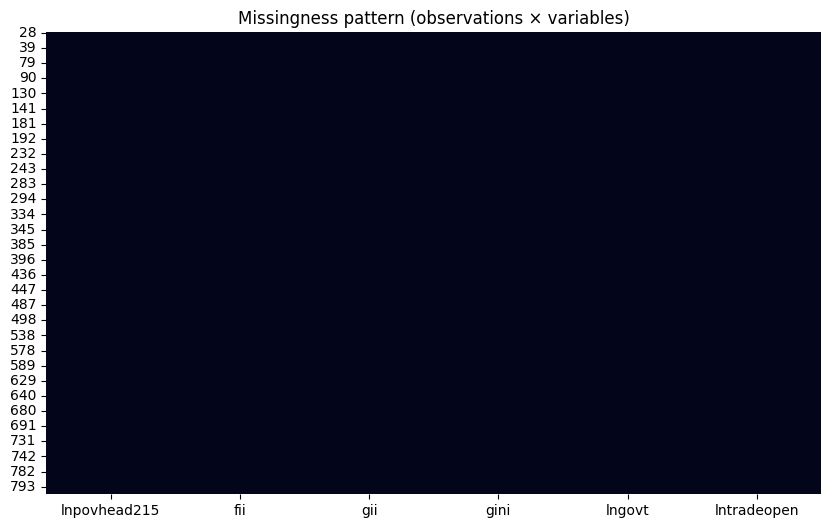

In [13]:

# Visualise missingness pattern for selected variables
key_vars = ['lnpovhead215','lnpovhead','fii','gii','gini','lngovt','lntradeopen']
key_vars = [v for v in key_vars if v in panel_df.columns]

plt.figure(figsize=(10,6))
sns.heatmap(panel_df[key_vars].isna(), cbar=False)
plt.title('Missingness pattern (observations × variables)')
plt.show()


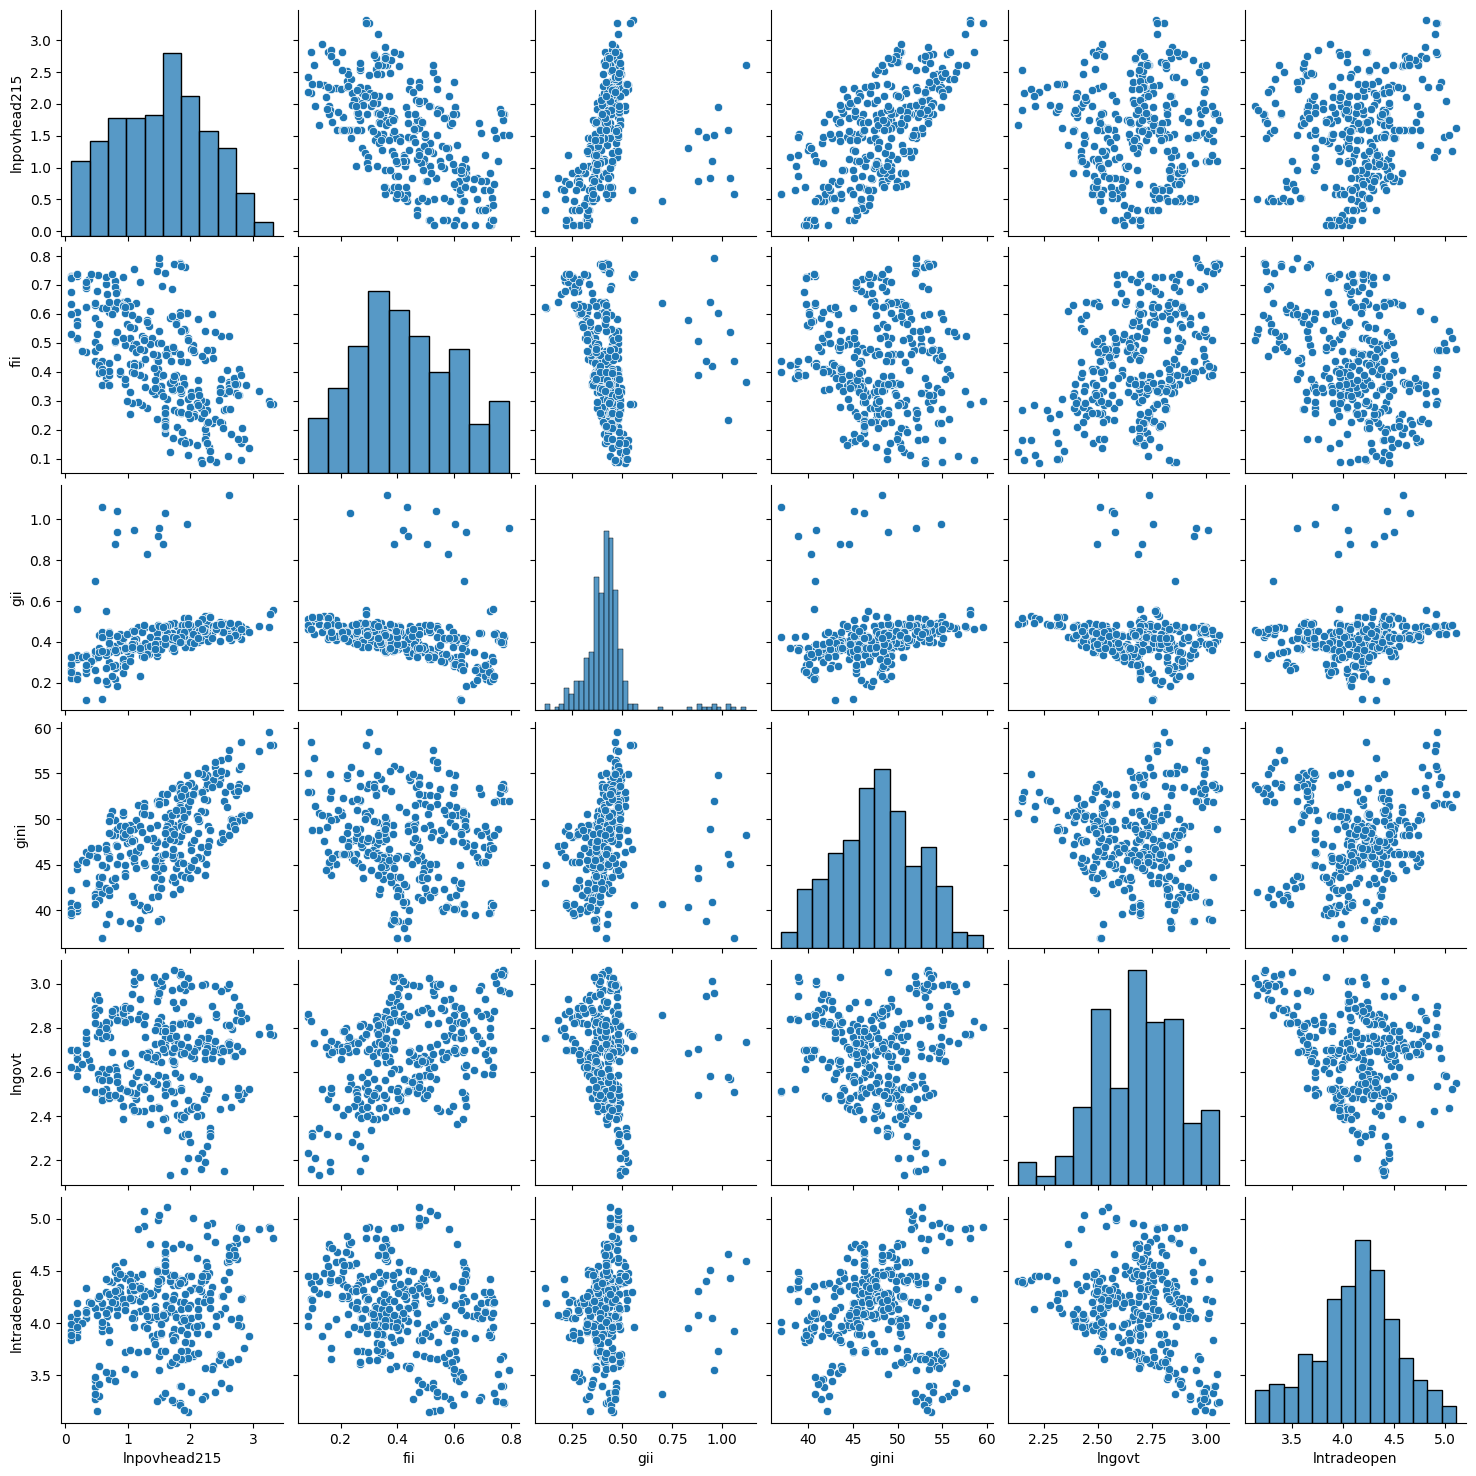

In [14]:

# Quick pairplot (sample) to spot relationships
sample_df = panel_df[key_vars].dropna().sample(n=min(500, len(panel_df)), random_state=42)
sns.pairplot(sample_df)


## 2  Descriptive analysis

In [15]:

# Country‑level summary stats
country_stats = (panel_df
                 .groupby('Country')
                 .agg({'lnpovhead215':['mean','std'],
                       'fii':['mean','std'],
                       'gini':['mean','std'],
                       'gii':['mean','std']}))
country_stats.head()


lnpovhead215                 fii                 gini            \
                  mean       std      mean       std       mean       std   
Country                                                                     
Argentina     0.795043  0.399624  0.467776  0.135694  43.654762  2.831338   
Bolivia       1.863419  0.524018  0.295755  0.121195  47.735714  5.484960   
Brazil        1.868325  0.370012  0.654839  0.121551  53.557143  1.901729   
Chile         0.761537  0.441394  0.636106  0.082827  46.707143  2.016237   
Colombia      2.128971  0.311543  0.480869  0.120689  53.252381  1.744438   

                gii            
               mean       std  
Country                        
Argentina  0.358810  0.087826  
Bolivia    0.453152  0.117396  
Brazil     0.463238  0.116593  
Chile      0.296952  0.088412  
Colombia   0.473095  0.120932

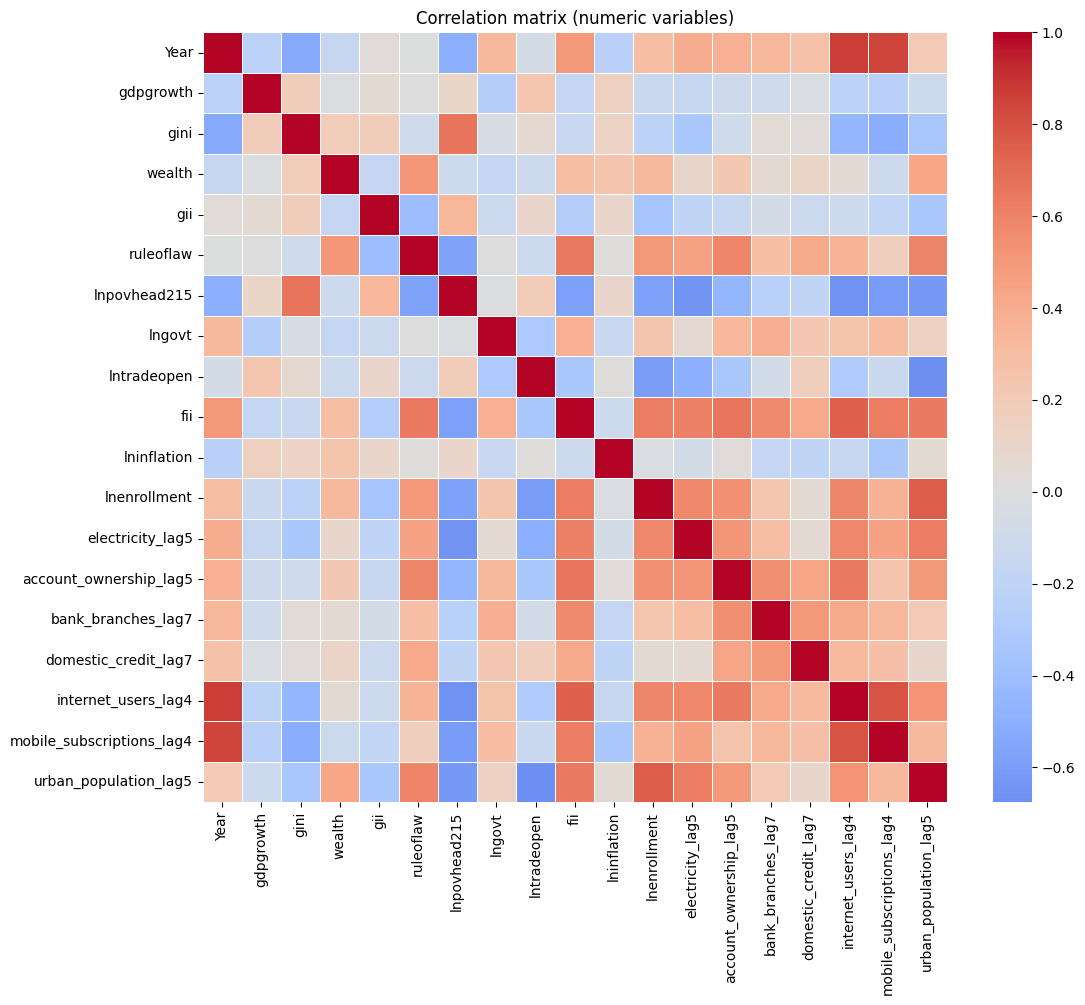

In [22]:

# Correlation heatmap (numeric variables)
numeric_cols = panel_df.select_dtypes(include='number').columns
corr = panel_df[numeric_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Correlation matrix (numeric variables)')
plt.show()


## 3  Econometric models

### 3.1 Fixed‑effects baseline

In [23]:

panel_mi = panel_df.set_index(['Country','Year'])
res_fe = run_fe(panel_mi, y='lnpovhead215')


Fixed Effects Model Results (Dependent Variable: lnpovhead215)
                          PanelOLS Estimation Summary                           
Dep. Variable:           lnpovhead215   R-squared:                        0.0355
Estimator:                   PanelOLS   R-squared (Between):              0.1421
No. Observations:                 336   R-squared (Within):               0.0903
Date:                 Fr, Mai 09 2025   R-squared (Overall):              0.1241
Time:                        22:50:51   Log-likelihood                    57.015
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.6470
Entities:                          16   P-value                           0.0131
Avg Obs:                       21.000   Distribution:                   F(3,297)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-stat

### 3.2 IV fixed‑effects

In [18]:
# Specify the instruments explicitly
instruments = ['account_ownership_lag5', 'bank_branches_lag7', 'domestic_credit_lag7']

# Run the IV fixed-effects model
res_iv = run_iv_fe(panel_mi, y='lnpovhead215', instruments=instruments)


IV2SLS FE‐IV Model Results (lnpovhead215)
                          IV-2SLS Estimation Summary                          
Dep. Variable:           lnpovhead215   R-squared:                      0.9127
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9012
No. Observations:                 336   F-statistic:                -1.077e+16
Date:                Fri, May 09 2025   P-value (F-stat)                1.0000
Time:                        22:49:59   Distribution:                F(39,296)
Cov. Estimator:             clustered                                         
                                                                              
                                        Parameter Estimates                                         
                                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------------
Intercept              

### 3.3 Interaction model – FI × Gender Inequality Index

In [28]:

res_inter = run_interaction(panel_mi.reset_index(), modifier='gini', y='lnpovhead215')


Interaction Model Results (Dependent Variable: lnpovhead215, Modifier: gini)
                          PanelOLS Estimation Summary                           
Dep. Variable:           lnpovhead215   R-squared:                        0.2903
Estimator:                   PanelOLS   R-squared (Between):              0.1341
No. Observations:                 336   R-squared (Within):               0.6503
Date:                 Fr, Mai 09 2025   R-squared (Overall):              0.1682
Time:                        22:54:57   Log-likelihood                    108.55
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      20.044
Entities:                          16   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                   F(6,294)
Min Obs:                       21.000                                           
Max Obs:                       2

### 3.4 Interaction model – FI × Gender Inequality Index

In [25]:

res_inter = run_interaction(panel_mi.reset_index(), modifier='gii', y='lnpovhead215')


Interaction Model Results (Dependent Variable: lnpovhead215, Modifier: gii)
                          PanelOLS Estimation Summary                           
Dep. Variable:           lnpovhead215   R-squared:                        0.0914
Estimator:                   PanelOLS   R-squared (Between):              0.0481
No. Observations:                 336   R-squared (Within):               0.1949
Date:                 Fr, Mai 09 2025   R-squared (Overall):              0.0578
Time:                        22:51:04   Log-likelihood                    67.037
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.9280
Entities:                          16   P-value                           0.0001
Avg Obs:                       21.000   Distribution:                   F(6,294)
Min Obs:                       21.000                                           
Max Obs:                       21

### 3.5 Interaction model – FI × Enrollment

In [ ]:
res_inter = run_interaction(panel_mi.reset_index(), modifier='lnenrollment', y='lnpovhead215')

Interaction Model Results (Dependent Variable: lnpovhead215, Modifier: lnenrollment)
                          PanelOLS Estimation Summary                           
Dep. Variable:           lnpovhead215   R-squared:                        0.2552
Estimator:                   PanelOLS   R-squared (Between):             -37.431
No. Observations:                 336   R-squared (Within):               0.3664
Date:                 Fr, Mai 09 2025   R-squared (Overall):             -34.935
Time:                        22:52:49   Log-likelihood                    100.44
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      16.792
Entities:                          16   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                   F(6,294)
Min Obs:                       21.000                                           
Max Obs:                

### 3.4 Time‑trend augmented model

In [20]:

res_trend = run_fe_trend(panel_mi, y='lnpovhead215')


Fixed Effects with Time Trend Model Results (Dependent Variable: lnpovhead215)
                          PanelOLS Estimation Summary                           
Dep. Variable:           lnpovhead215   R-squared:                        0.7779
Estimator:                   PanelOLS   R-squared (Between):             -0.8508
No. Observations:                 336   R-squared (Within):               0.7779
Date:                Fri, May 09 2025   R-squared (Overall):             -0.7433
Time:                        22:49:59   Log-likelihood                    52.876
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      183.25
Entities:                          16   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                   F(6,314)
Min Obs:                       21.000                                           
Max Obs:                      

## 4  Conclusion
This single notebook contains all Python code from the project and reproduces each step from data ingestion to advanced econometric analysis. No separate `.py` files are required for assessment.